In [1]:
import os, mne, pyxdf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

['AF7', 'Fp1', 'Fp2', 'AF8']
Creating RawArray with float64 data, n_channels=4, n_times=196834
    Range : 0 ... 196833 =      0.000 ...   787.332 secs
Ready.
Using matplotlib as 2D backend.


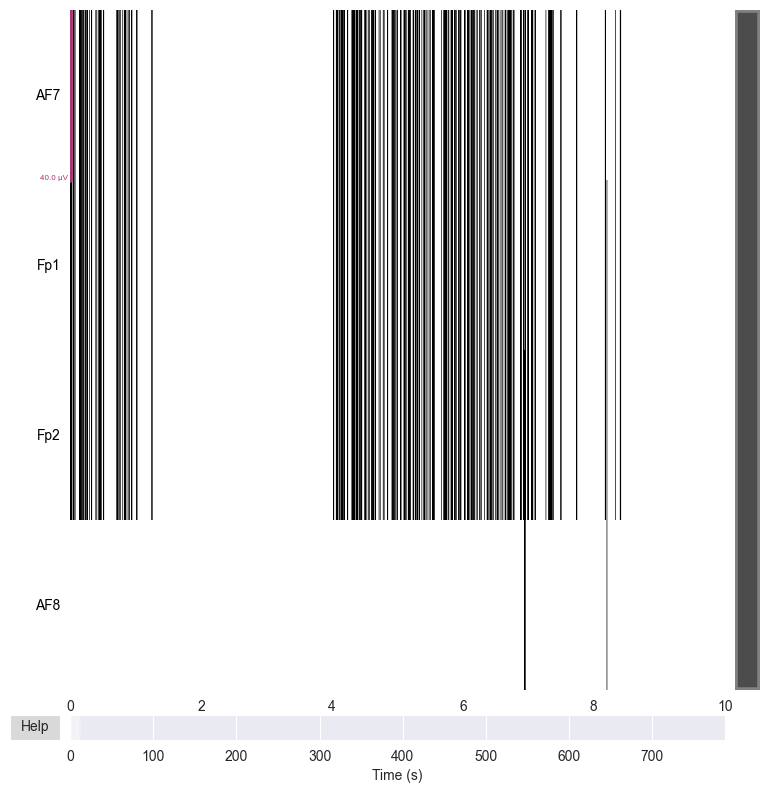

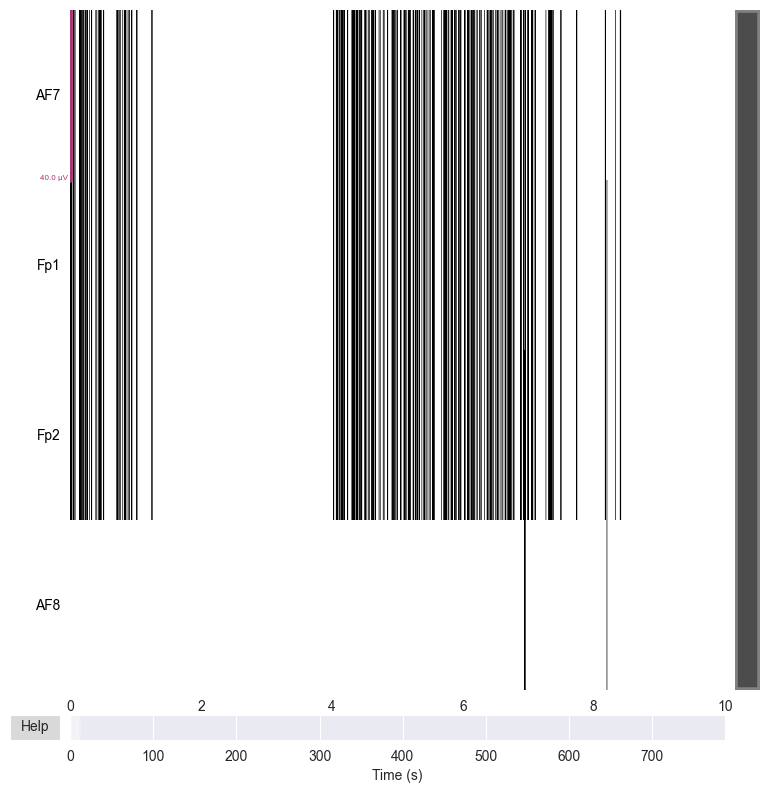

In [2]:
file_path = os.getcwd() + '/sub-001/sub-001_ses-S001_task-Default_run-001_eeg.xdf'
streams, fileheader = pyxdf.load_xdf(file_path)

# Extract the EEG stream
eeg_stream = None
for stream in streams:
    if stream['info']['type'][0] == 'EEG':
        eeg_stream = stream
        break
if eeg_stream is None:
    raise ValueError('No EEG stream found')

# Extract the marker stream
marker_stream = None
for stream in streams:
    if stream['info']['type'][0] == 'Markers':
        marker_stream = stream
        break
if marker_stream is not None:
    markers = marker_stream['time_series']
    timestamps = marker_stream['time_stamps']
    marker_info = list(zip(markers, timestamps))
else:
    marker_info = "No markers found in the file."

# Create the MNE RawArray object
sfreq = float(eeg_stream['info']['nominal_srate'][0])  # Sampling frequency
ch_names = [ch['label'][0] for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']]  
print(ch_names)
eeg_data = np.array(eeg_stream['time_series']).T
eeg_data = eeg_data[:4]
# print(eeg_data)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)
raw.plot()


# import data

In [3]:
file_path = os.getcwd() + '/sub-001/sub-001_ses-S001_task-Default_run-001_eeg.xdf'
data, header = pyxdf.load_xdf(file_path)

markers = []
timestamps = []
first_timestamp = None

# Extract markers and corresponding timestamps
for stream in data:
    if stream['info']['type'][0] == 'Markers':
        markers = stream['time_series']
        timestamps = stream['time_stamps']

# Find the first timestamp 
for stream in data:
    if stream['info']['type'][0] == 'EEG':
        first_timestamp = stream['time_stamps'][0]
        break

# Load the cleaned EEG data
cleaned_eeg_path = 'sub-001/sub-001_eeg_cleaned.fif'
raw_cleaned = mne.io.read_raw_fif(cleaned_eeg_path, preload=True)

# Assuming first_timestamp and markers are correctly identified
if first_timestamp is not None and markers:
    sfreq = raw_cleaned.info['sfreq']  # Sampling frequency
    marker_info = list(zip(markers, timestamps))
    print(f"First timestamp: {first_timestamp}")
    # print(f"Number of markers: {len(marker_info)}")
    print(marker_info)
    print('')
    # Convert marker onset times to samples relative to the first EEG data timestamp
    events = np.array([
        [int((timestamp - first_timestamp) * sfreq), 0, int(marker[0])]
        for marker, timestamp in marker_info if marker[0].isdigit()  # Ensure marker is a digit
    ])

    # create epochs 
    epochs = mne.Epochs(raw_cleaned, events=events, event_id=None, tmin=-0.2, tmax=10.0, preload=True, reject=None,
                        baseline=(-0.2, 0))
    print(epochs)
else:
    print("No markers found or first_timestamp not set.")


Opening raw data file sub-001/sub-001_eeg_cleaned.fif...
Isotrak not found
    Range : 0 ... 196833 =      0.000 ...   787.332 secs
Ready.
Reading 0 ... 196833  =      0.000 ...   787.332 secs...
First timestamp: 35683.144898086946
[(['11'], 35694.925218511664), (['1'], 35976.06085388924), (['2'], 36010.02777423821), (['3'], 36044.14817518694), (['4'], 36123.88359566714), (['12'], 36142.57725133905), (['5'], 36336.52012904764), (['6'], 36371.57937259496), (['7'], 36406.30540294278), (['8'], 36440.65430099118), ([''], 36462.8001621579)]

Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 10 events and 2551 original time points ...
0 bad epochs dropped
<Epochs |  10 events (all good), -0.2 – 10 s, baseline -0.2 – 0 s, ~807 kB, data loaded,
 '1': 1
 '2': 1
 '3': 1
 '4': 1
 '5': 1
 '6': 1
 '7': 1
 '8': 1
 '11': 1
 '12': 1>


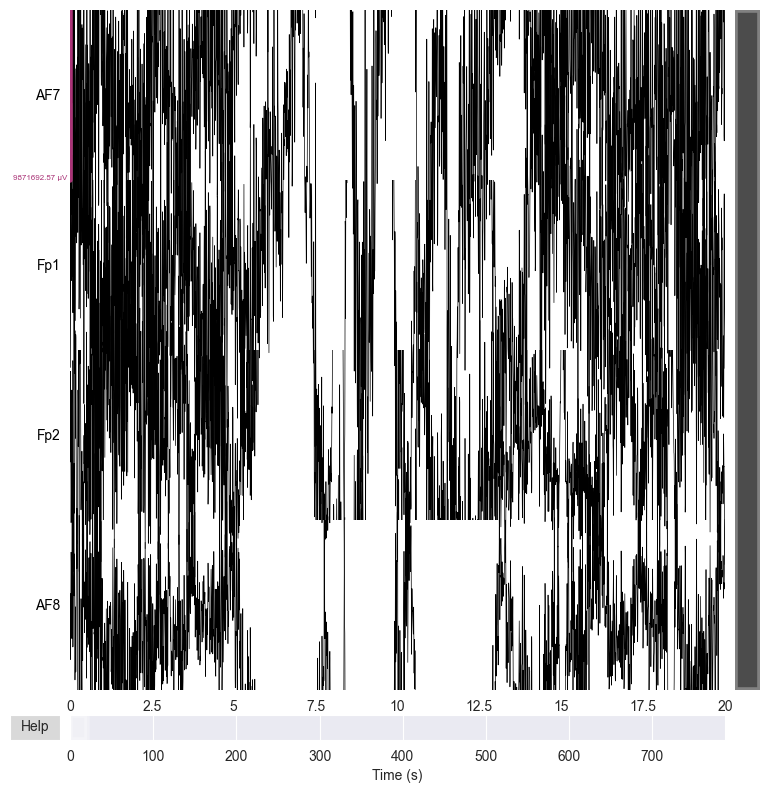

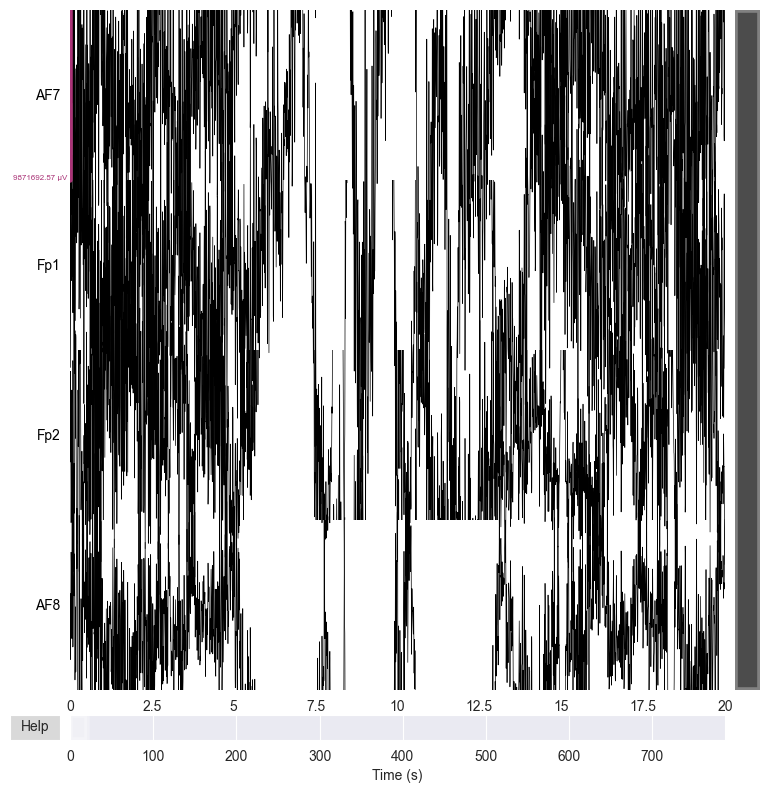

In [4]:
raw_cleaned.plot(scalings='auto', duration=20)

In [5]:
# 'first_timestamp' is the timestamp of the first EEG data sample
events = np.array([
    [int((timestamp - first_timestamp) * sfreq), 0, int(marker[0])]
    for marker, timestamp in marker_info if marker[0].isdigit()
])
events

array([[  2945,      0,     11],
       [ 73228,      0,      1],
       [ 81720,      0,      2],
       [ 90250,      0,      3],
       [110184,      0,      4],
       [114858,      0,     12],
       [163343,      0,      5],
       [172108,      0,      6],
       [180790,      0,      7],
       [189377,      0,      8]])

In [6]:
epochs = mne.Epochs(raw_cleaned, events=events, event_id=None, tmin=-0.2, tmax=10.0, preload=True, reject=None,
                    baseline=(-0.2, 0))
print(epochs)

Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 10 events and 2551 original time points ...
0 bad epochs dropped
<Epochs |  10 events (all good), -0.2 – 10 s, baseline -0.2 – 0 s, ~807 kB, data loaded,
 '1': 1
 '2': 1
 '3': 1
 '4': 1
 '5': 1
 '6': 1
 '7': 1
 '8': 1
 '11': 1
 '12': 1>


In [7]:
print(raw_cleaned.times[-1])  # the last timestamp in the recording
# print(raw_cleaned.info['highpass'])
# print(raw_cleaned.info['lowpass'])
print(raw_cleaned.info['bads'])

787.332
[]


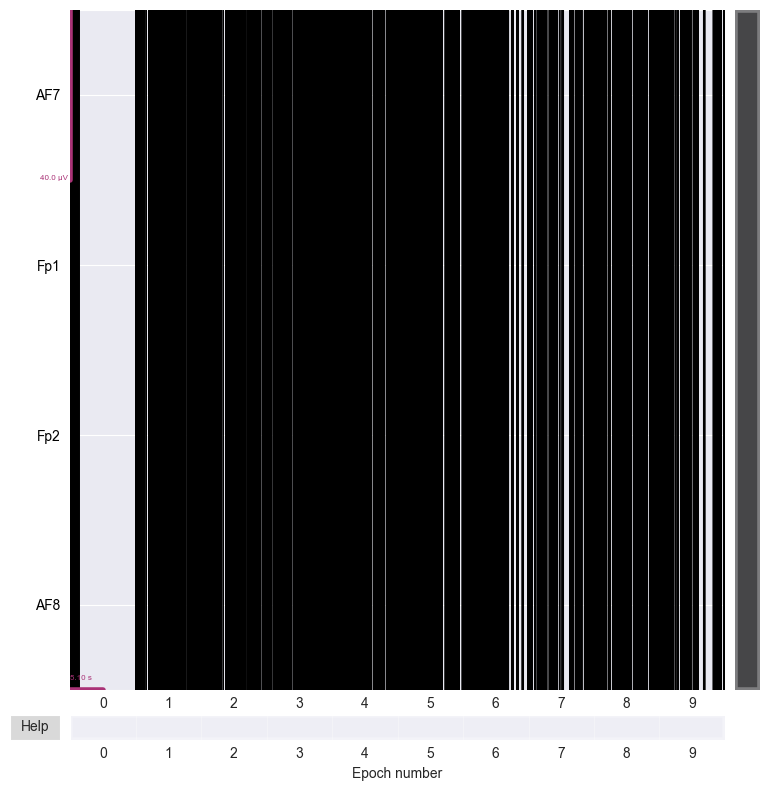

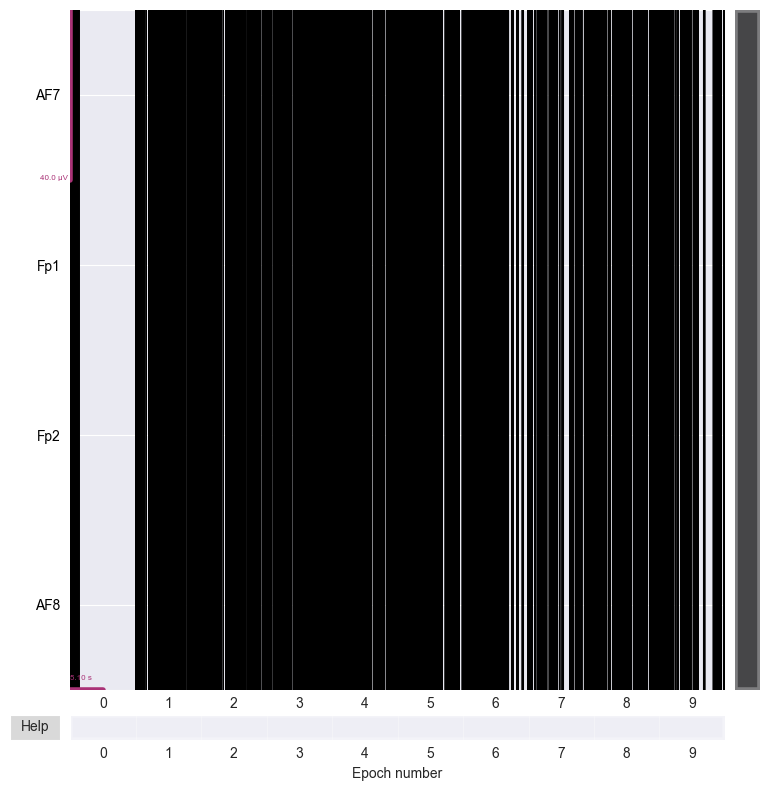

In [8]:
epochs.plot()

In [9]:
# Get the index of AF7 and AF8 channels
af7_index = epochs.ch_names.index('AF7')
af8_index = epochs.ch_names.index('AF8')
fp1_index = epochs.ch_names.index('Fp1')
fp2_index = epochs.ch_names.index('Fp2')
print(af7_index, af8_index) 
print(fp1_index, fp2_index)

0 3
1 2


# alpha power

Not setting metadata
Applying baseline correction (mode: logratio)


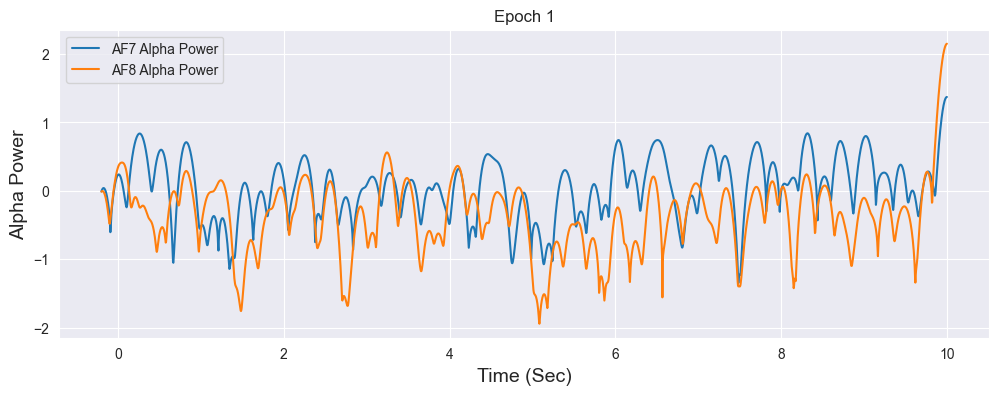

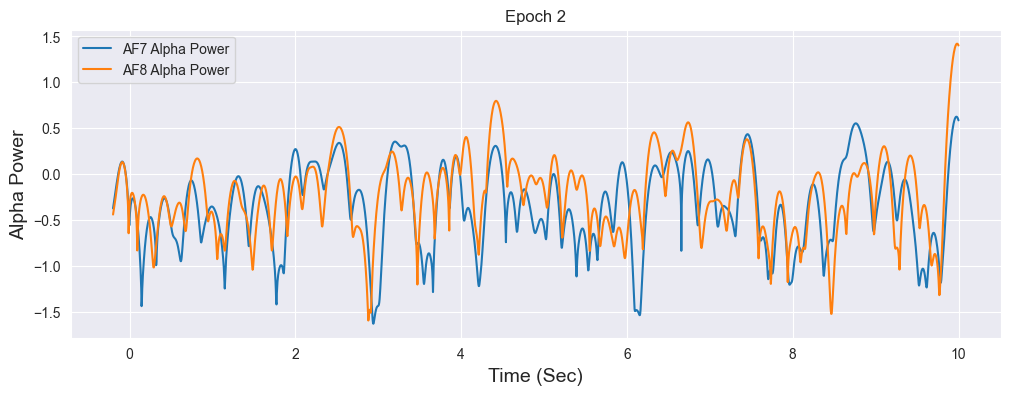

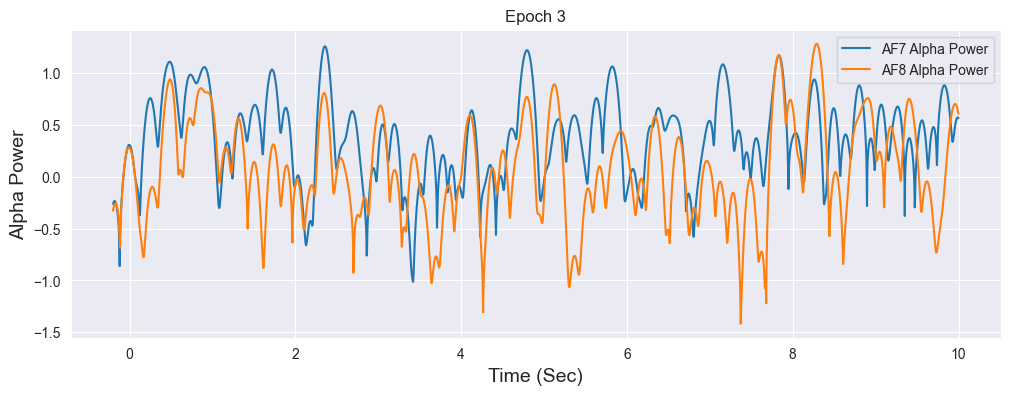

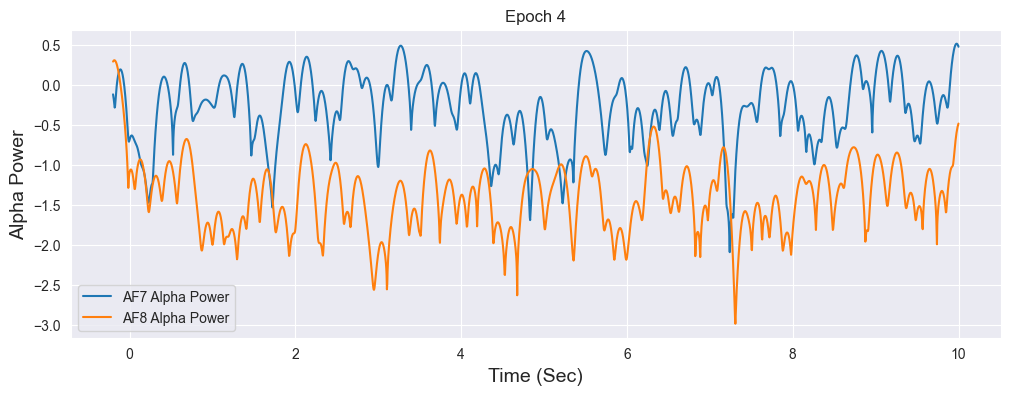

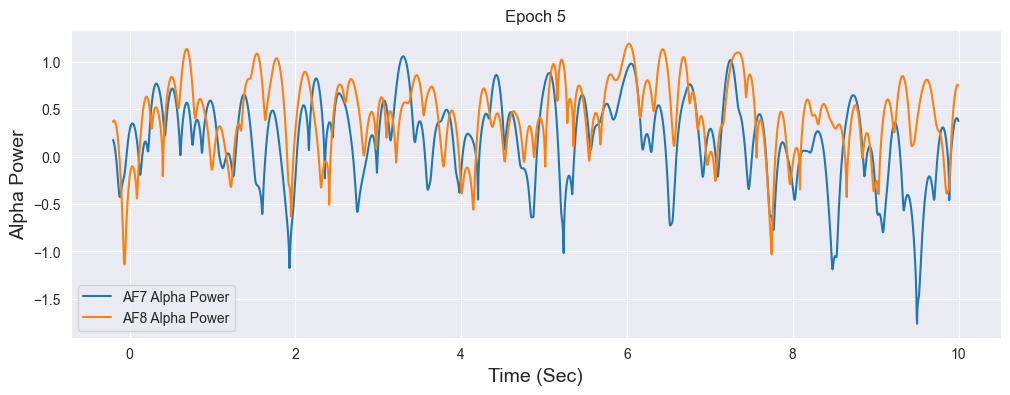

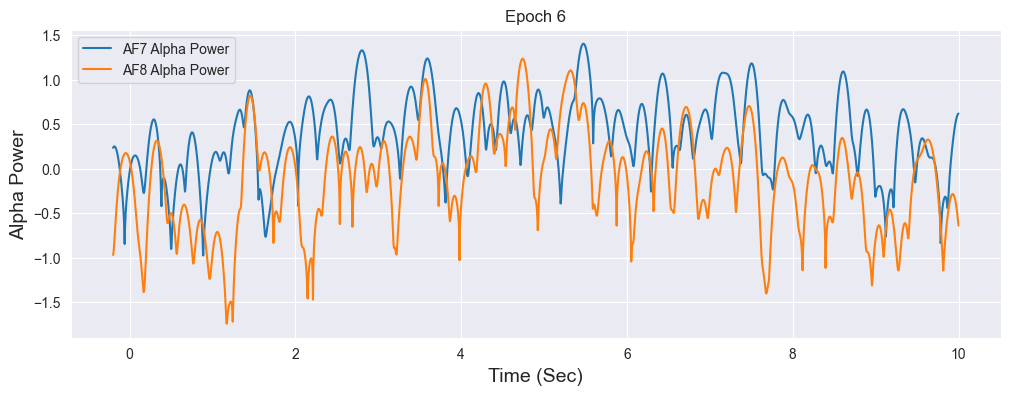

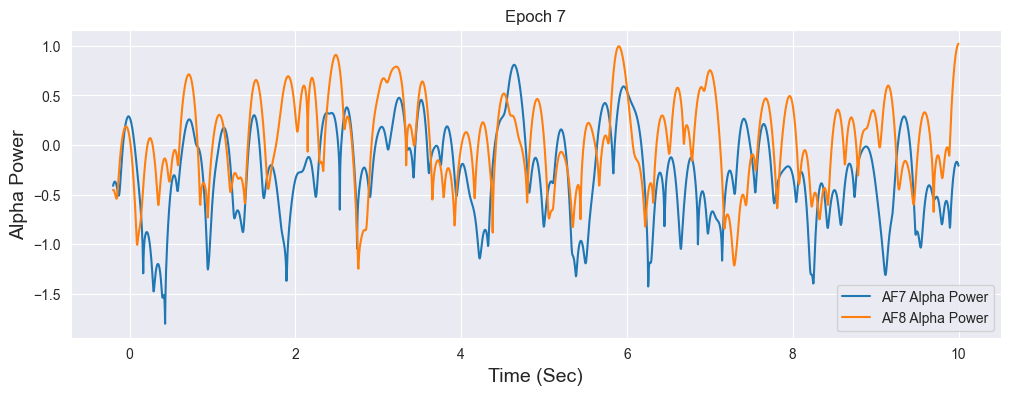

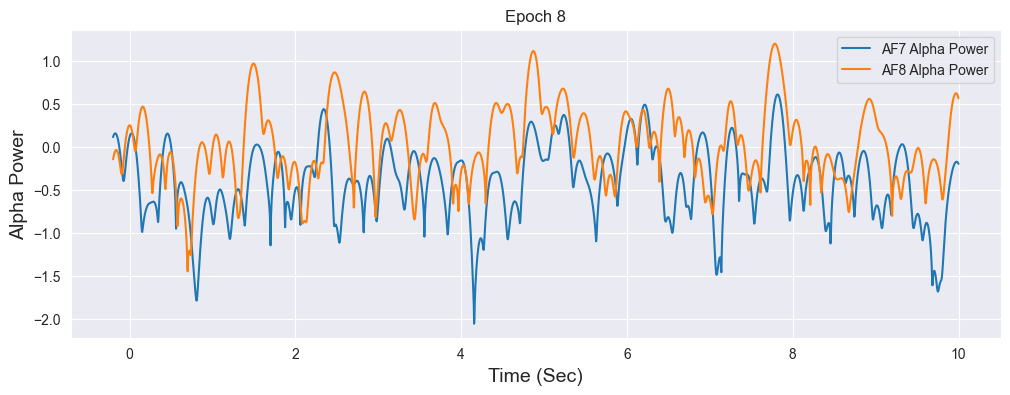

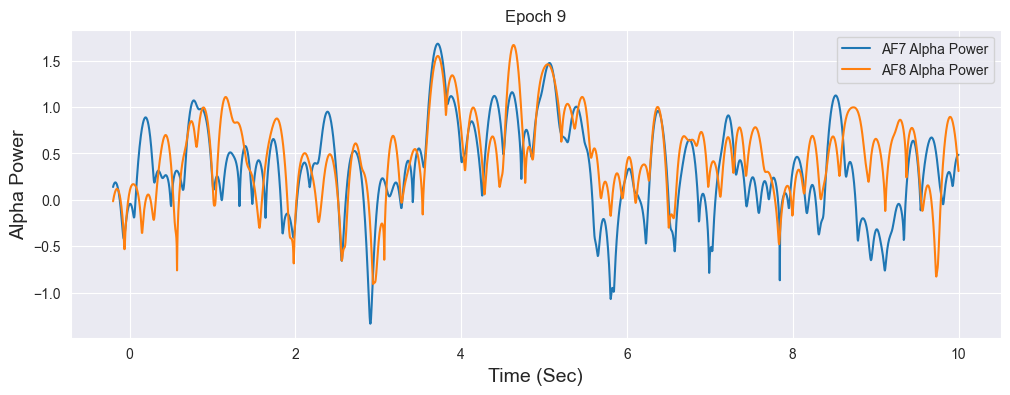

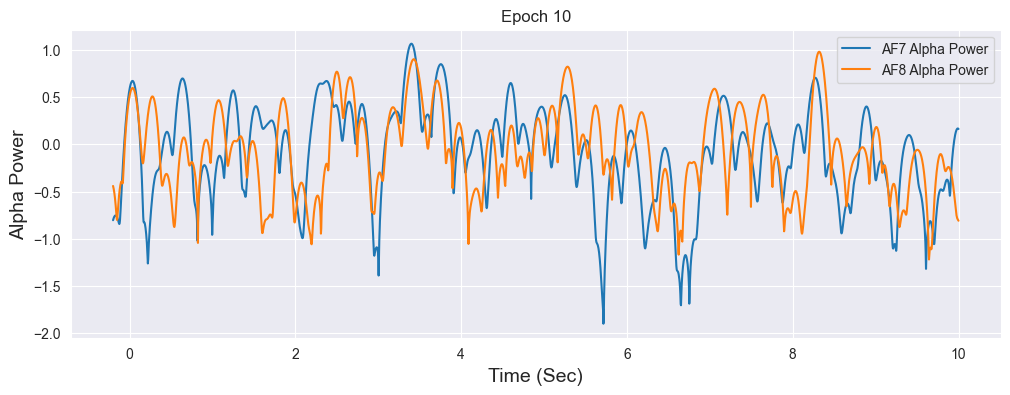

In [10]:
# Define frequency range for alpha band
alpha_freqs = np.arange(8, 13, 1)  # 8 to 12 Hz, in steps of 1 Hz

# Compute time-frequency representation (TFR) of alpha power using Morlet wavelets
tfr_power = mne.time_frequency.tfr_morlet(epochs, freqs=alpha_freqs, n_cycles=alpha_freqs / 2,
                                          return_itc=False, average=False)

# Define baseline period for baseline correction
baseline_period = (-0.2, 0)
tfr_power.apply_baseline(baseline=baseline_period, mode='logratio')

# Compute average alpha power across frequency dimension
alpha_power = tfr_power.data.mean(axis=2)

# Get time points
time_points = tfr_power.times

# Define indices for AF7 and AF8 channels
af7_index = 0  # AF7
af8_index = 3  # AF8

# Plot alpha power for each epoch
for i in range(alpha_power.shape[0]):
    plt.figure(figsize=(12, 4))

    # Plot alpha power for AF7 and AF8 channels
    plt.plot(time_points, alpha_power[i, af7_index, :], label='AF7 Alpha Power')
    plt.plot(time_points, alpha_power[i, af8_index, :], label='AF8 Alpha Power')

    plt.title(f'Epoch {i+1}')
    plt.xlabel('Time (Sec)', fontsize=14)
    plt.ylabel('Alpha Power', fontsize=14)
    plt.legend()
    plt.show()


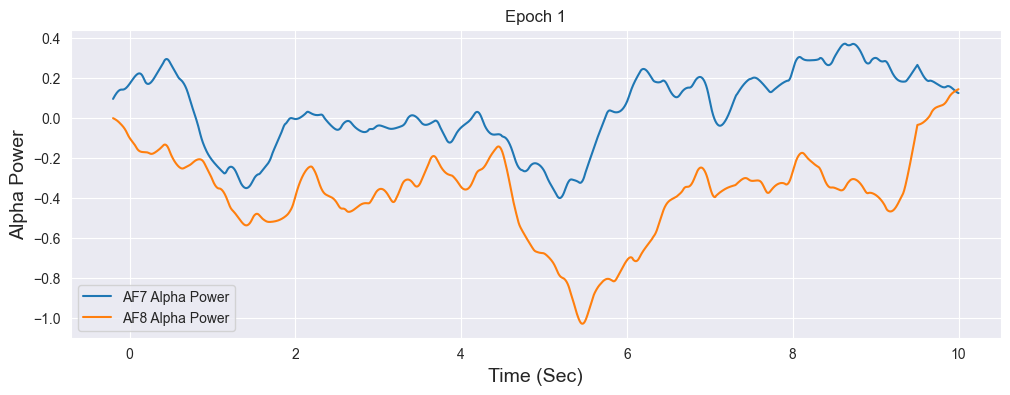

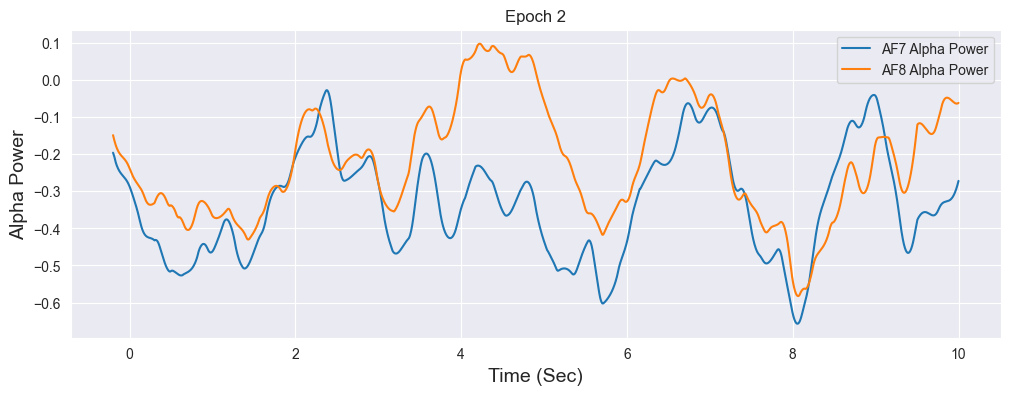

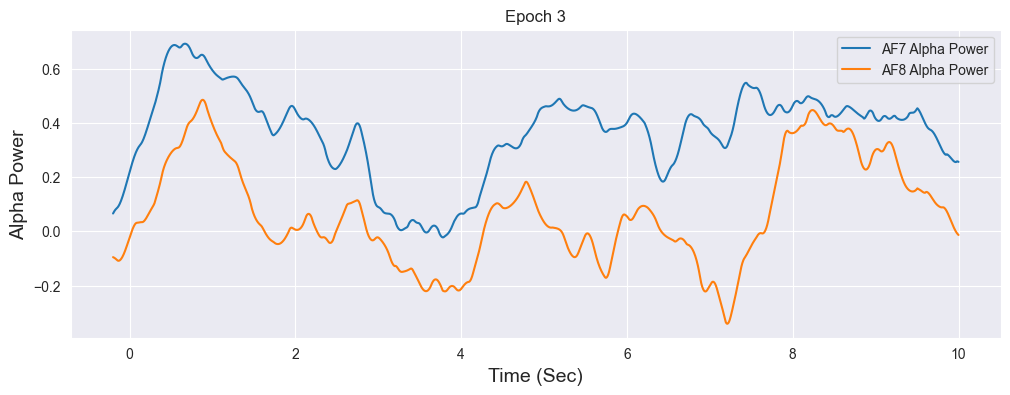

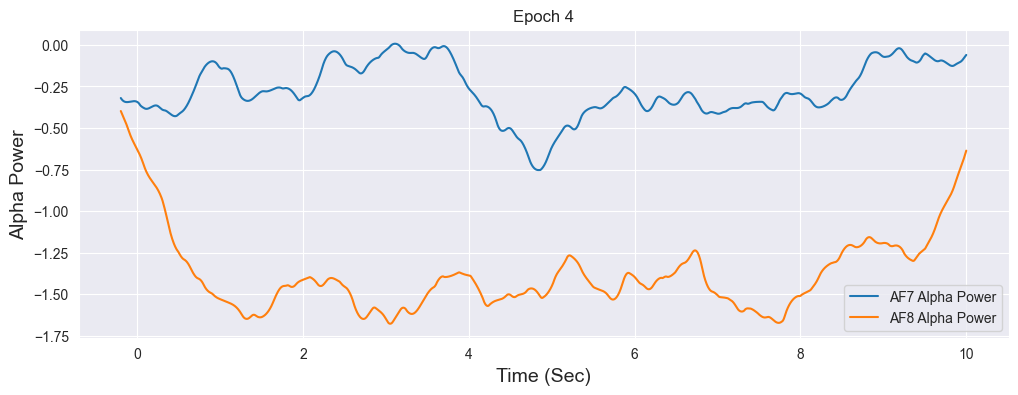

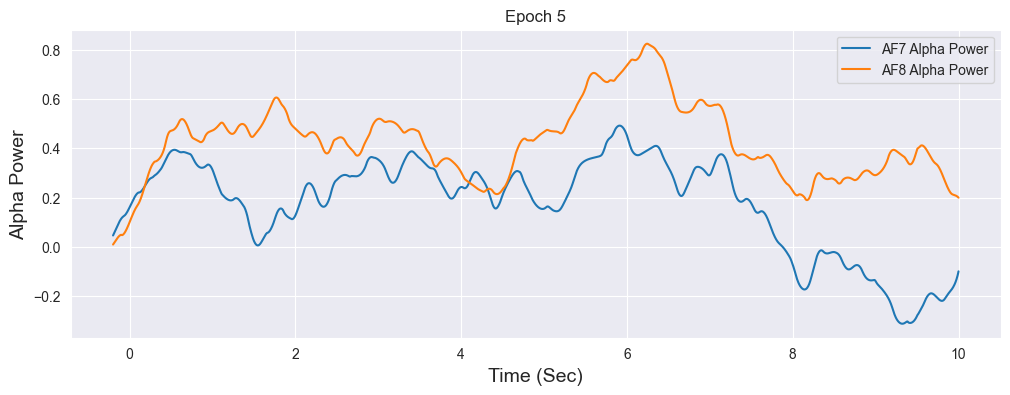

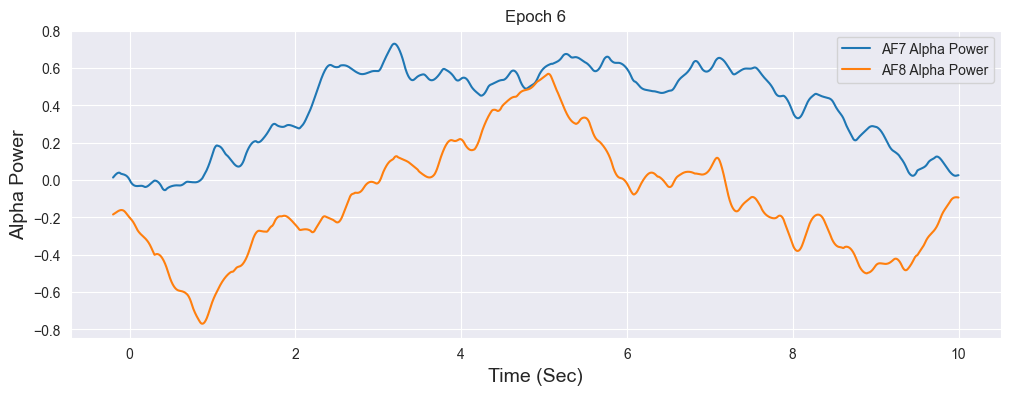

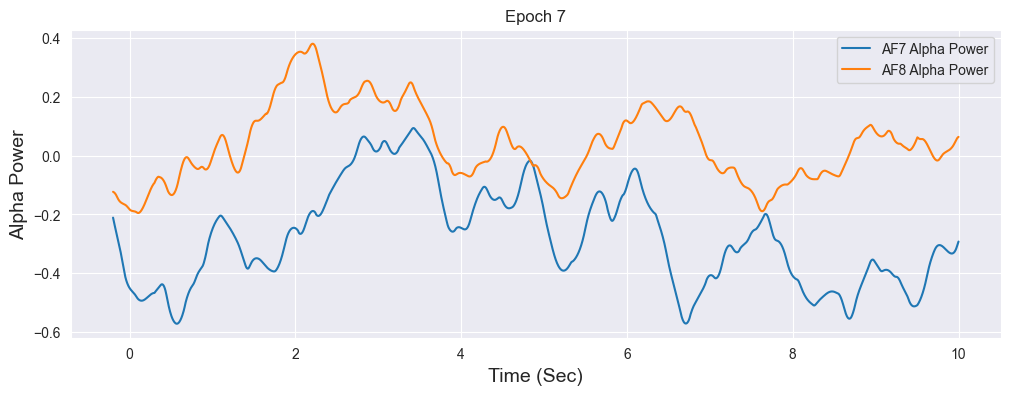

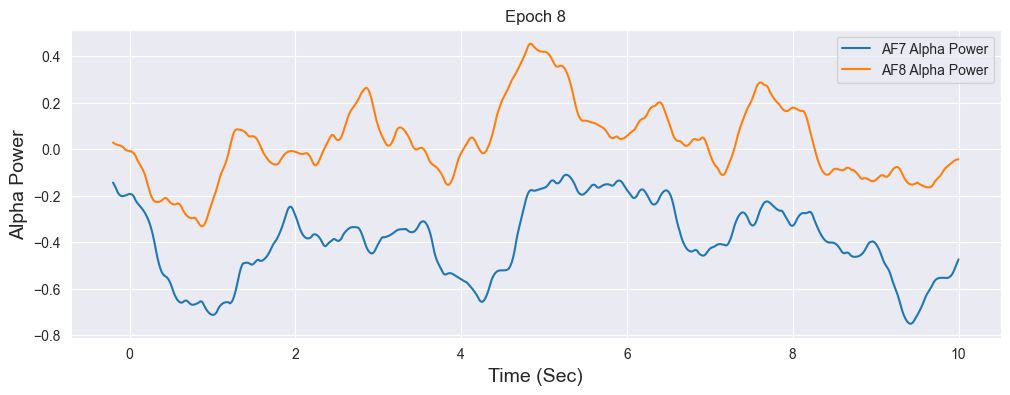

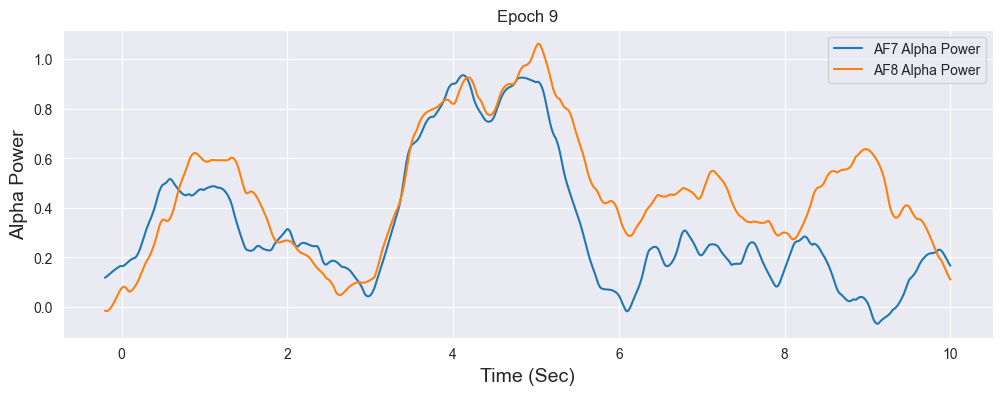

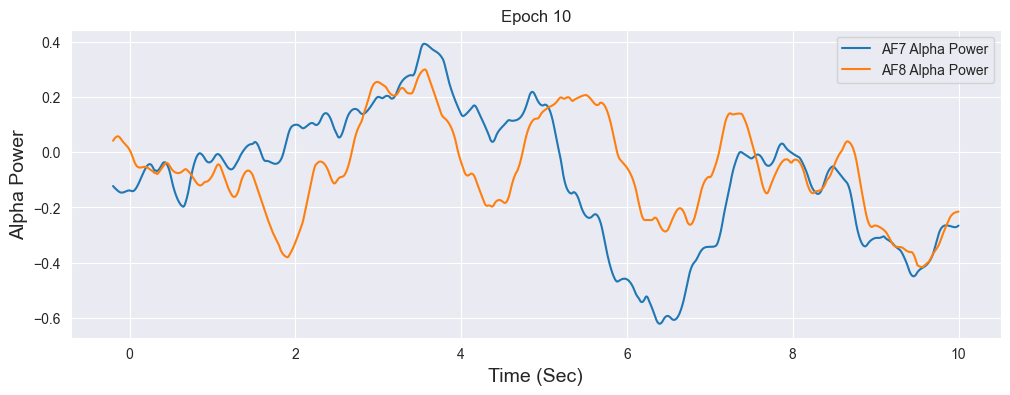

In [11]:
# Define moving average function
def moving_average(data, window_size=50):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='same')

# Calculate average alpha power across frequency dimension
alpha_power = tfr_power.data.mean(axis=2)
time_points = tfr_power.times

# Define indices for AF7 and AF8 channels
af7_index = 0  # AF7
af8_index = 3  # AF8

# Plot the smoothed alpha power for each epoch
for i in range(alpha_power.shape[0]):  
    # Calculate the moving average for each channel's alpha power
    smoothed_af7_alpha_power = moving_average(alpha_power[i, af7_index, :], window_size=250)
    smoothed_af8_alpha_power = moving_average(alpha_power[i, af8_index, :], window_size=250)

    plt.figure(figsize=(12, 4))
    plt.plot(time_points, smoothed_af7_alpha_power, label='AF7 Alpha Power')
    plt.plot(time_points, smoothed_af8_alpha_power, label='AF8 Alpha Power')

    plt.title(f'Epoch {i+1}')
    plt.xlabel('Time (Sec)', fontsize=14)
    plt.ylabel('Alpha Power', fontsize=14)
    plt.legend()
    plt.show()


# alpha asymmetry

Not setting metadata
Applying baseline correction (mode: logratio)


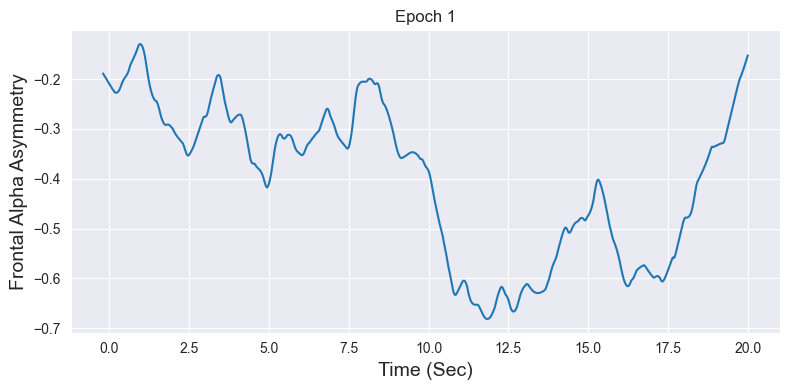

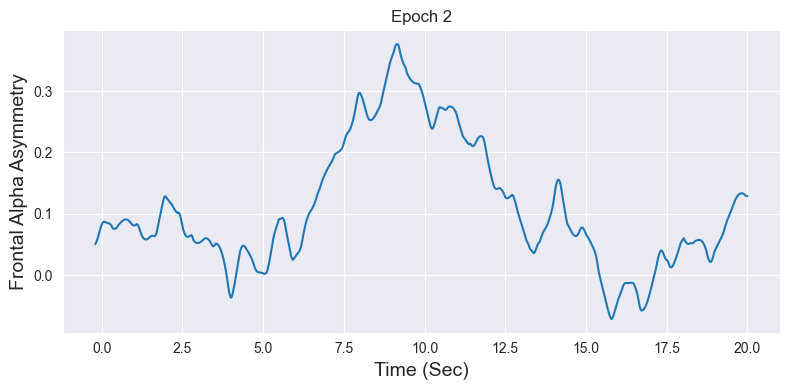

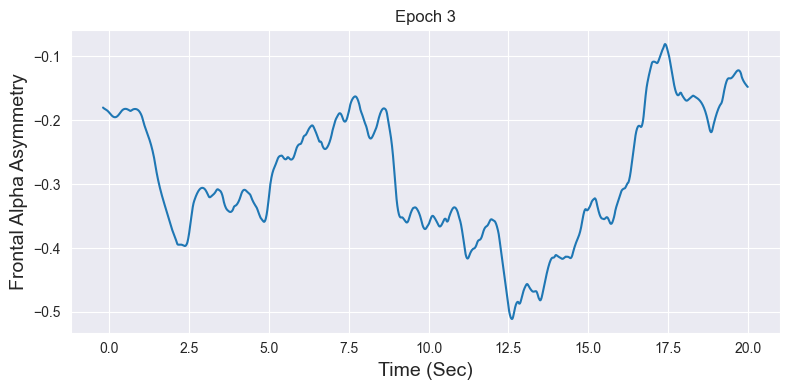

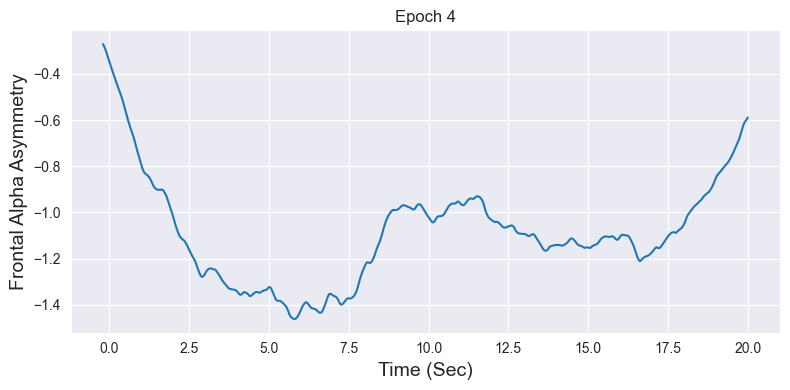

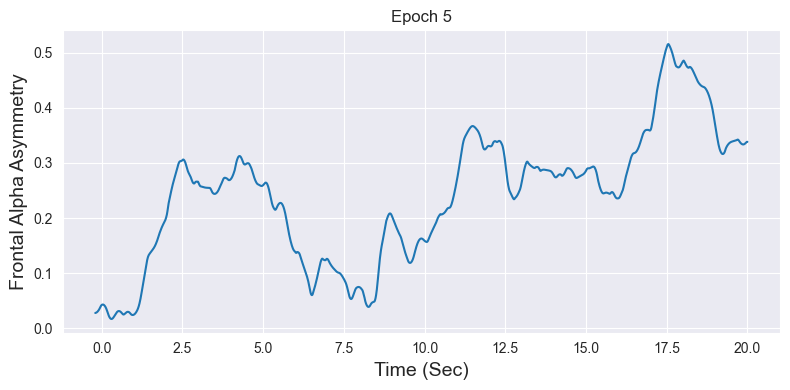

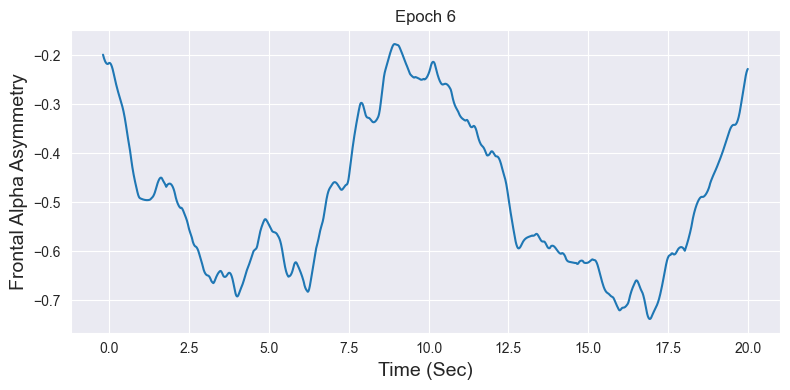

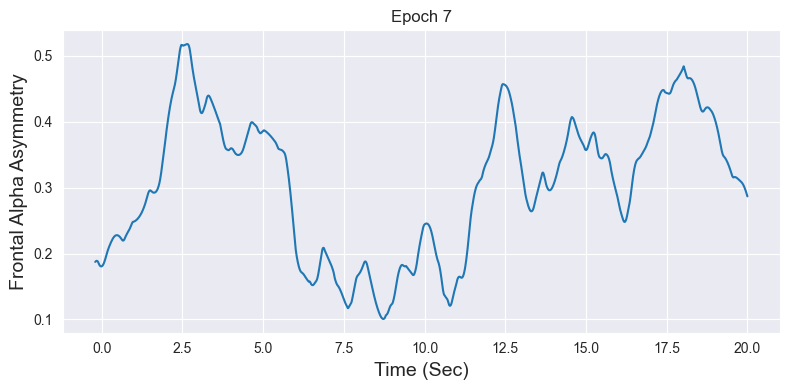

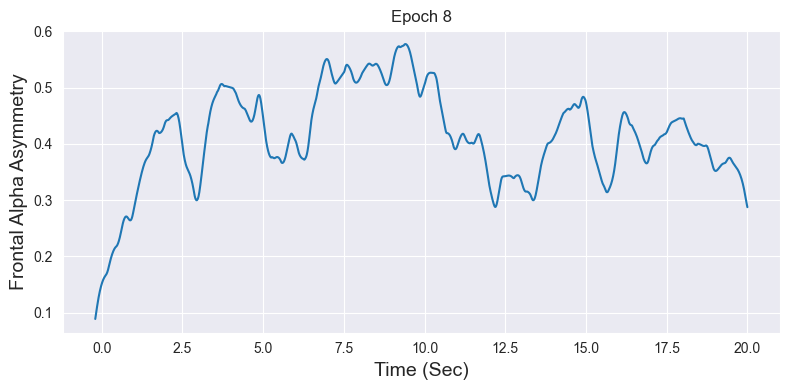

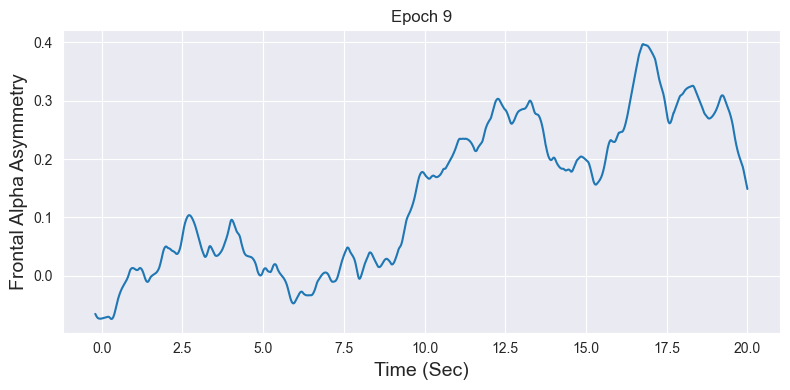

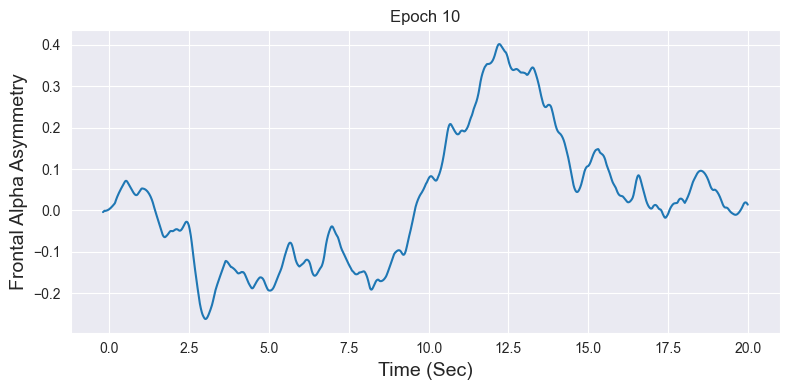

In [12]:
# regularization_constant = 0.1

# Apply moving average function 
def moving_average(data, window_size=5):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='same')

frequencies = np.arange(8, 13, 1)  # Alpha band: 8-12 Hz
n_cycles = frequencies / 2.  
power = mne.time_frequency.tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, return_itc=False, average=False)
power.apply_baseline(baseline=(-0.2, 0), mode='logratio') # baseline correction

alpha_band = power.copy().crop(fmin=8, fmax=13).data
n_epochs = alpha_band.shape[0]
time_points = np.linspace(-0.2, 20, alpha_band.shape[-1])

# Calculate and plot the frontal alpha asymmetry for each epoch
for i in range(n_epochs):
    # average across frequency
    af7_alpha_power = alpha_band[i, 0, :, :].mean(axis=0)  # AF7
    af8_alpha_power = alpha_band[i, 3, :, :].mean(axis=0)  # AF8

    # # Apply regularization constant before log transformation
    # af7_alpha_power += regularization_constant
    # af8_alpha_power += regularization_constant

    # Calculate the asymmetry index 
    asymmetry_index = af8_alpha_power - af7_alpha_power
    smoothed_asymmetry_index = moving_average(asymmetry_index, window_size=500)  

    plt.figure(figsize=(8, 4))
    plt.plot(time_points, smoothed_asymmetry_index)
    plt.title(f'Epoch {i+1}')
    plt.xlabel('Time (Sec)', fontsize=14)
    plt.ylabel('Frontal Alpha Asymmetry', fontsize=14)
    plt.tight_layout()
    plt.show()


# alpha suppression

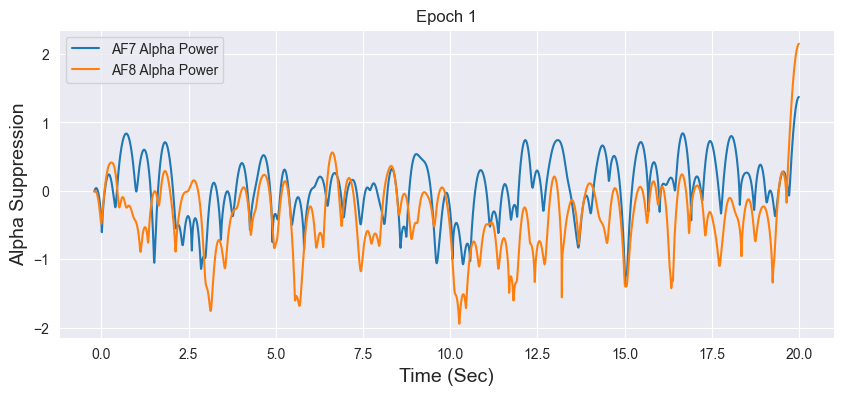

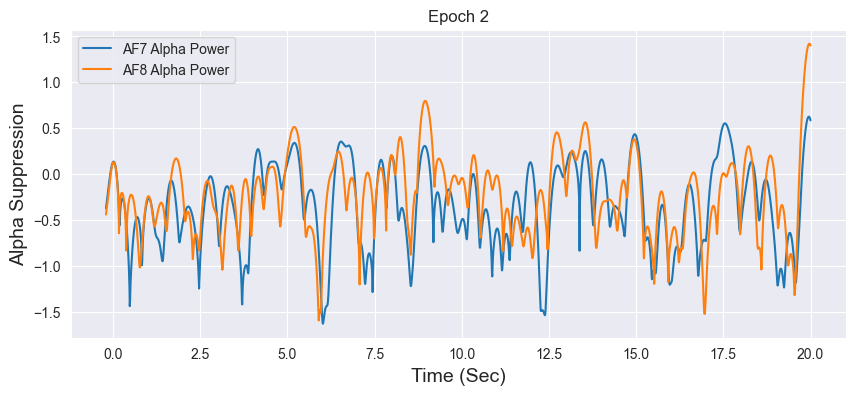

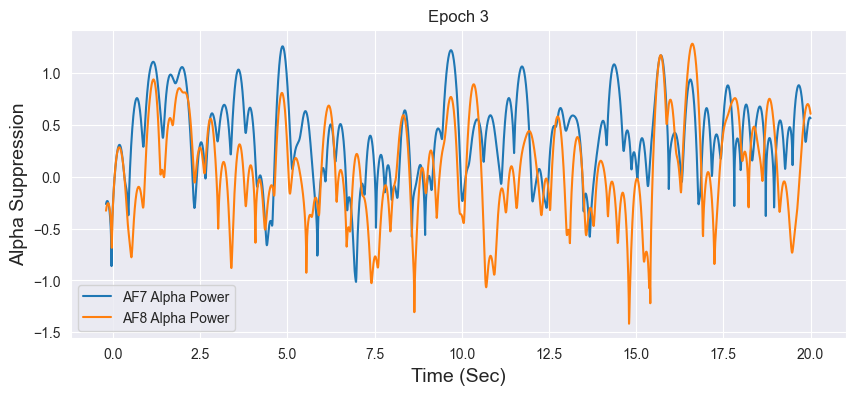

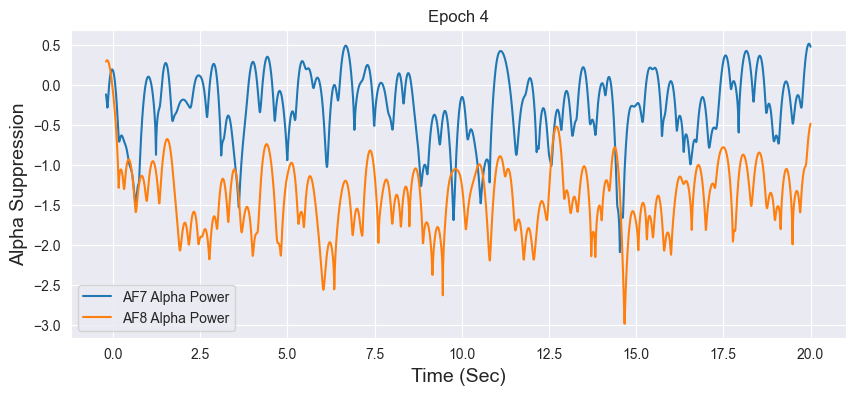

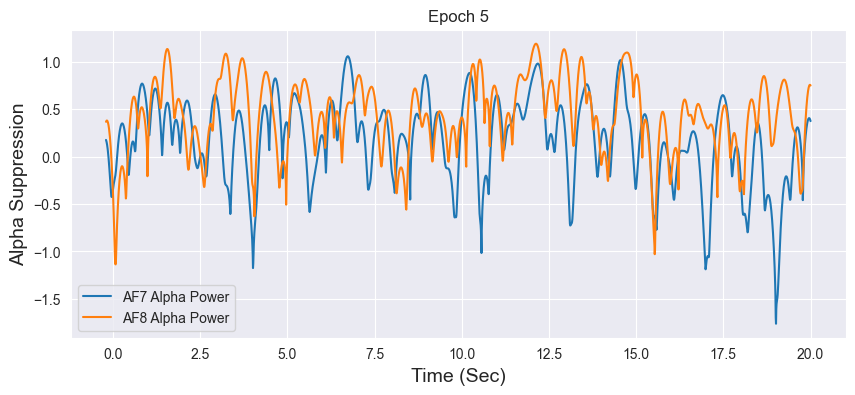

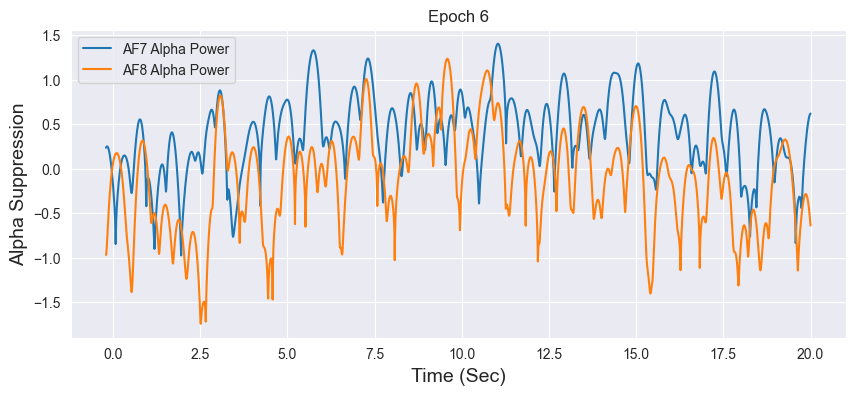

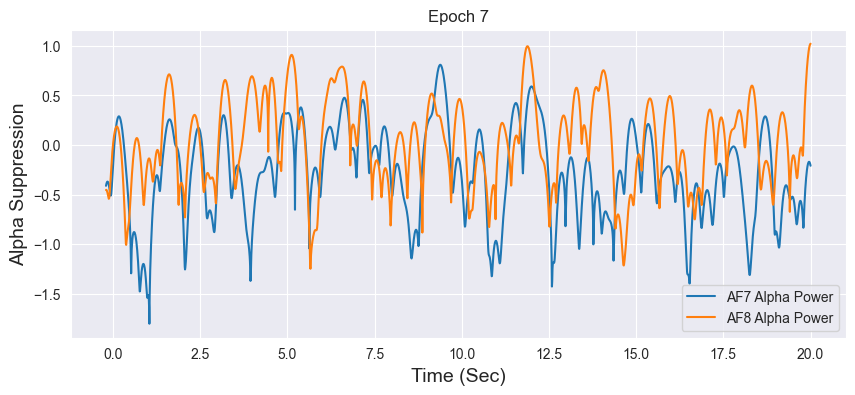

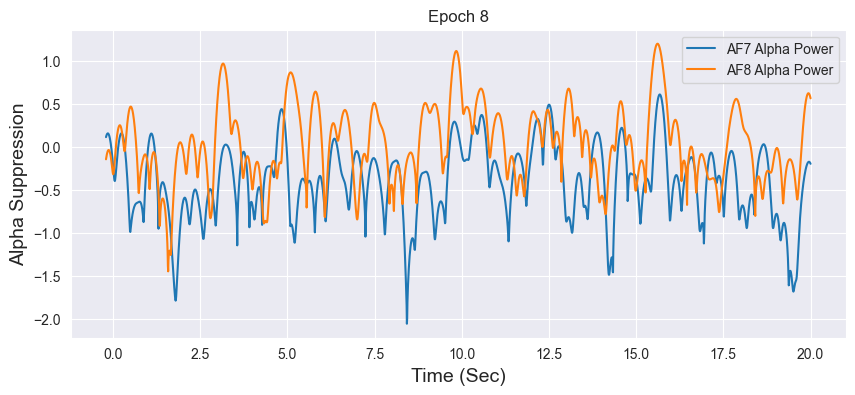

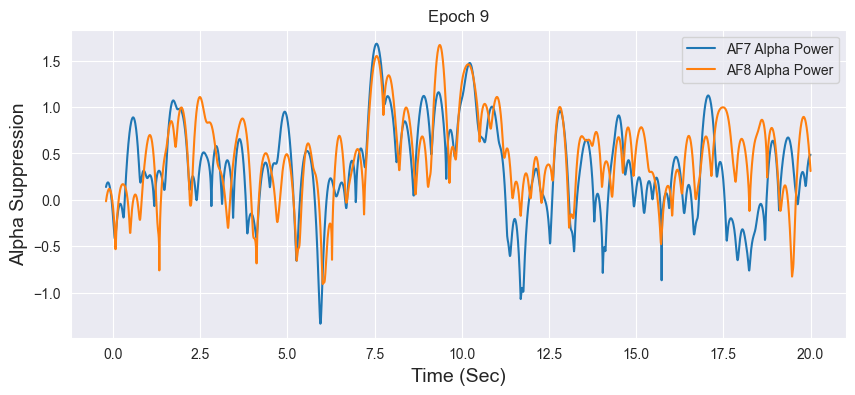

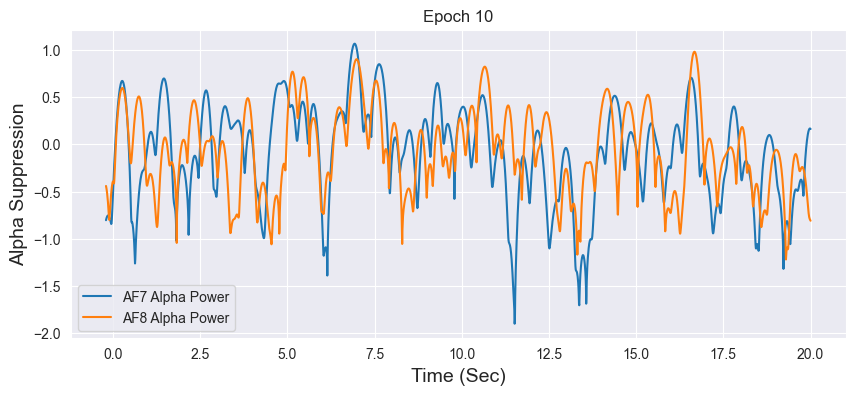

In [13]:
n_epochs, n_channels, n_freqs, n_times = alpha_band.shape

time_points = np.linspace(-0.2, 20, n_times)

# Calculate and plot the temporal dynamics of alpha suppression for each epoch
for i in range(n_epochs):
    alpha_power_epoch = alpha_band[i].mean(axis=1)  # Average over frequency dimension

    af7_alpha_power = alpha_power_epoch[0, :]  # AF7
    af8_alpha_power = alpha_power_epoch[3, :]  # AF8
    
    # log_af7_alpha_power = np.log(af7_alpha_power + 1e-6)  # Avoid log(0)
    # log_af8_alpha_power = np.log(af8_alpha_power + 1e-6)
    
    plt.figure(figsize=(10, 4))
    plt.plot(time_points, af7_alpha_power, label='AF7 Alpha Power')
    plt.plot(time_points, af8_alpha_power, label='AF8 Alpha Power')
    
    plt.title(f'Epoch {i+1}')
    plt.xlabel('Time (Sec)', fontsize=14)
    plt.ylabel('Alpha Suppression', fontsize=14)
    plt.legend()
    plt.show()


# theta power

Not setting metadata
Applying baseline correction (mode: logratio)


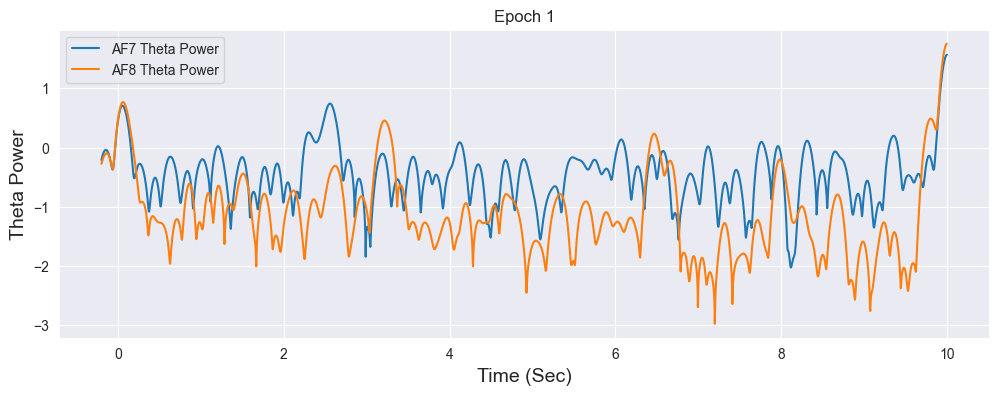

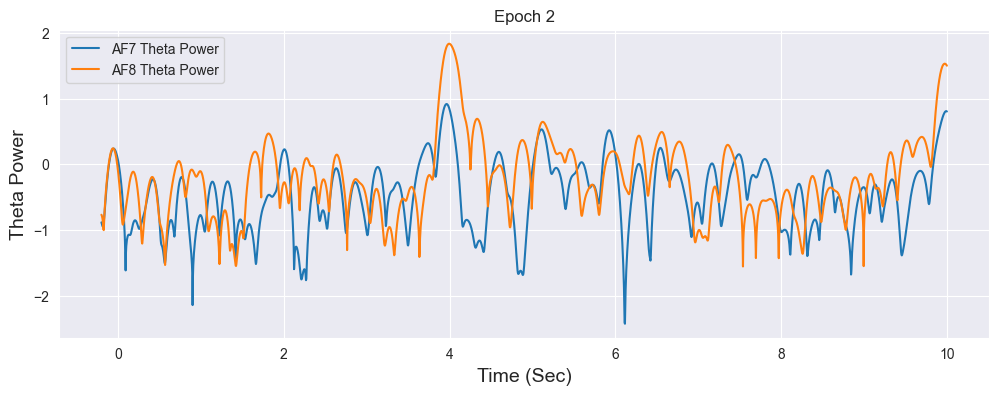

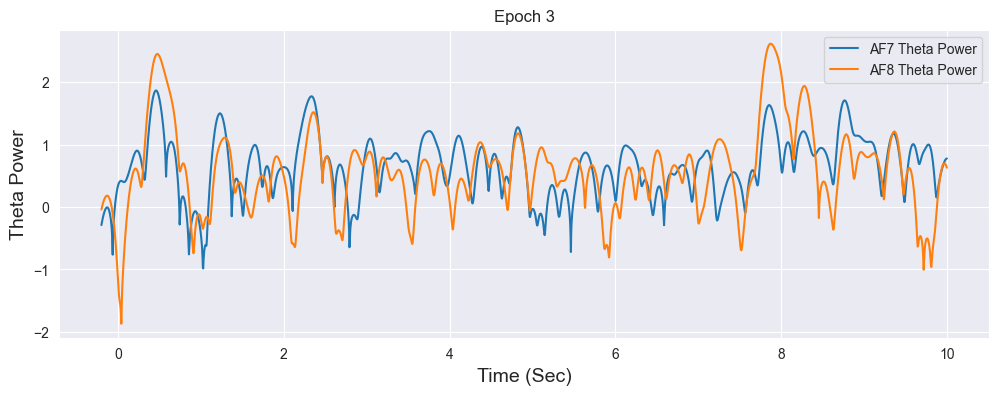

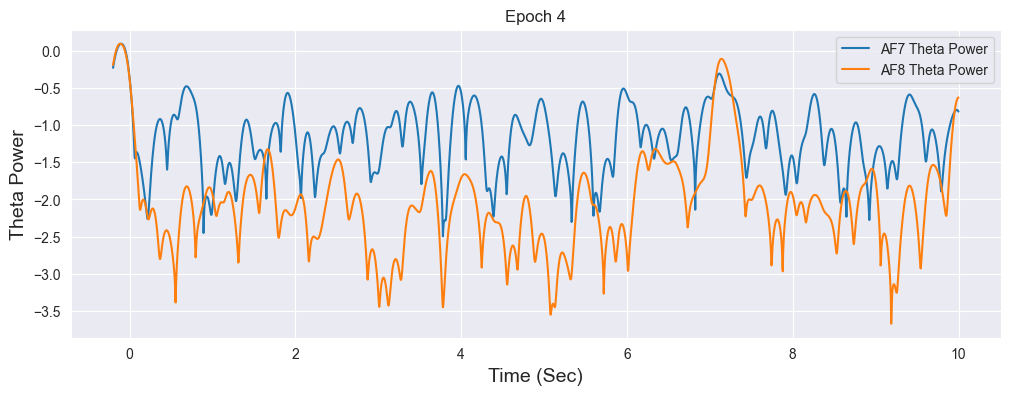

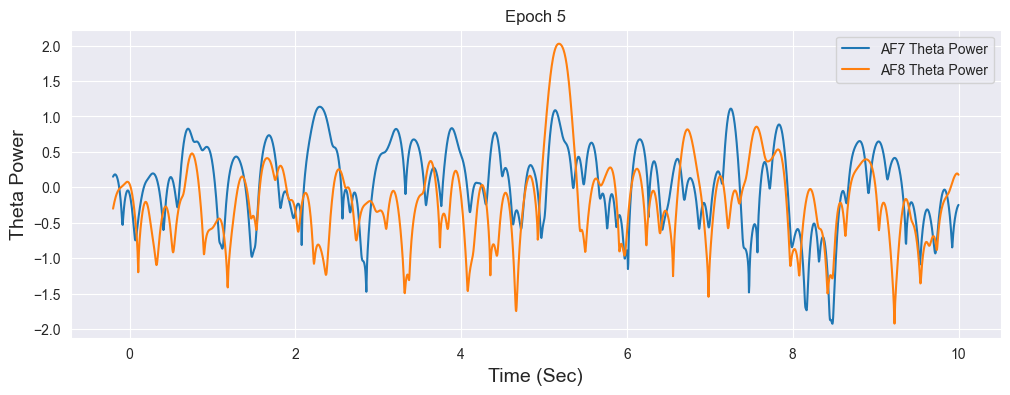

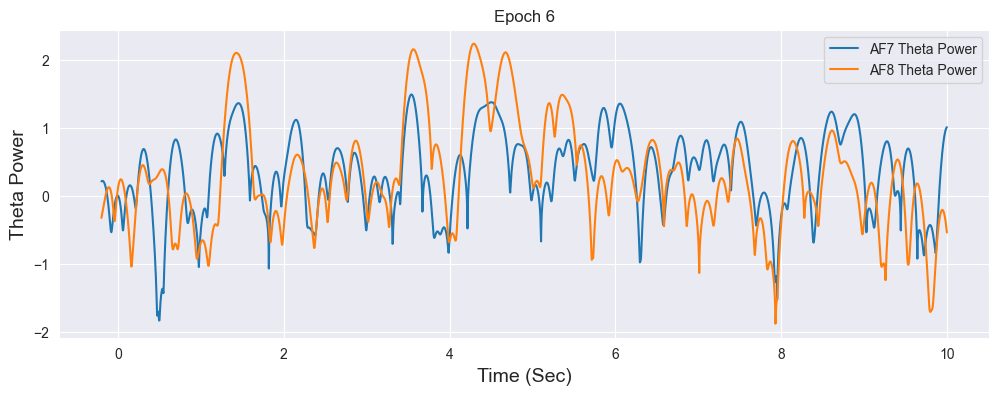

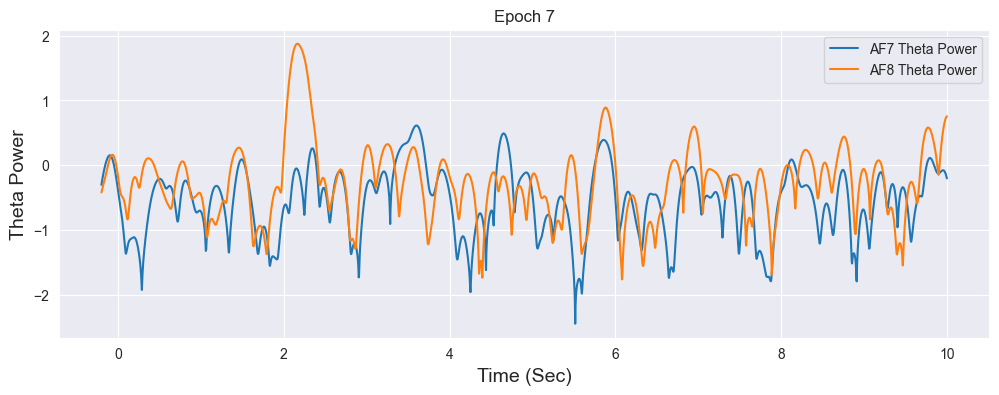

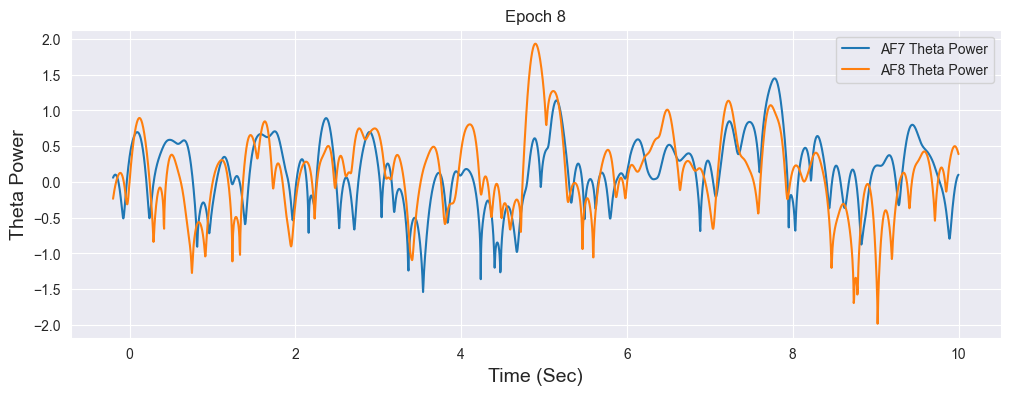

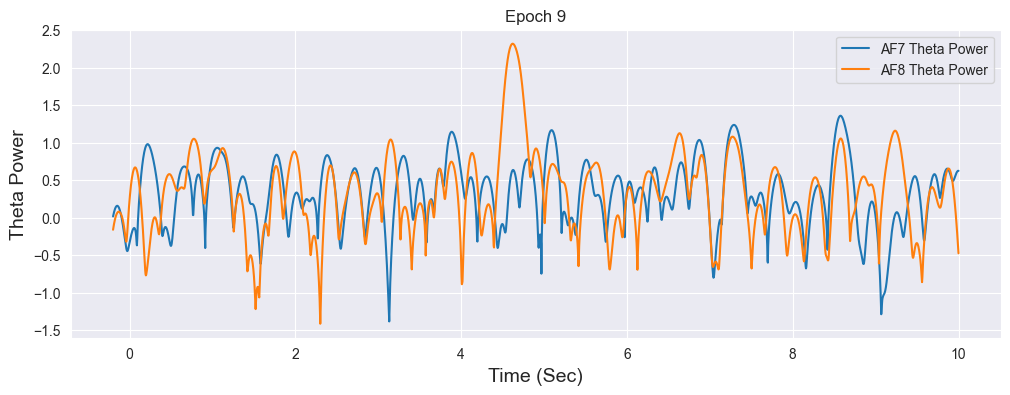

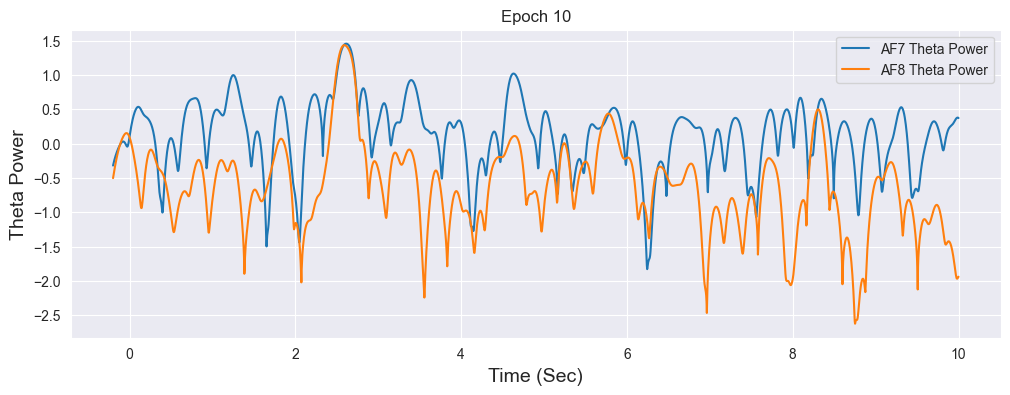

In [14]:
theta_freqs = np.arange(4, 8, 1)  # 4 to 7 Hz, in steps of 1 Hz

power = mne.time_frequency.tfr_morlet(epochs, freqs=theta_freqs, n_cycles=theta_freqs / 2,
                                      return_itc=False, average=False)

baseline_period = (-0.2, 0)  
power.apply_baseline(baseline_period, mode='logratio') # baseline correction

af7_index = 0  
af8_index = 3  
time_points = power.times  

# Plot the theta power for each epoch and channel
for i in range(len(power.data)):  
    # Extract theta power for each channel and average across theta frequencies
    af7_theta_power = power.data[i, af7_index, :, :].mean(axis=0)
    af8_theta_power = power.data[i, af8_index, :, :].mean(axis=0)

    plt.figure(figsize=(12, 4))
    plt.plot(time_points, af7_theta_power, label='AF7 Theta Power')
    plt.plot(time_points, af8_theta_power, label='AF8 Theta Power')

    plt.title(f'Epoch {i+1}')
    plt.xlabel('Time (Sec)', fontsize=14)
    plt.ylabel('Theta Power', fontsize=14)
    plt.legend()
    plt.show()


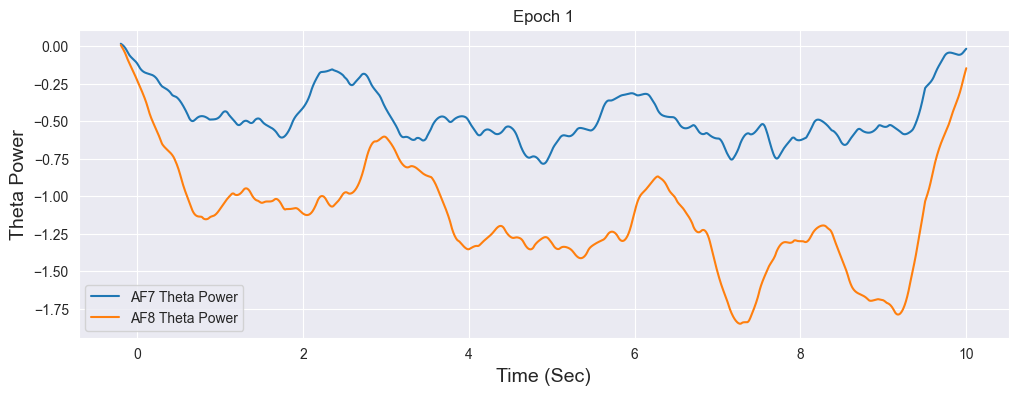

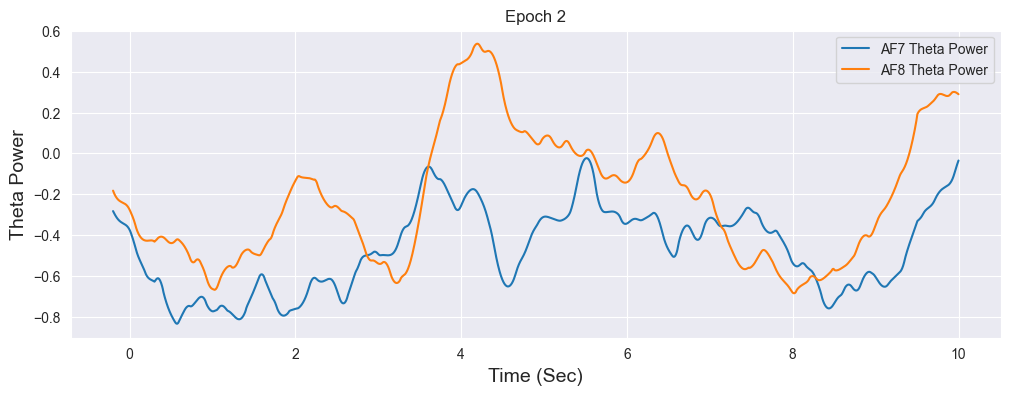

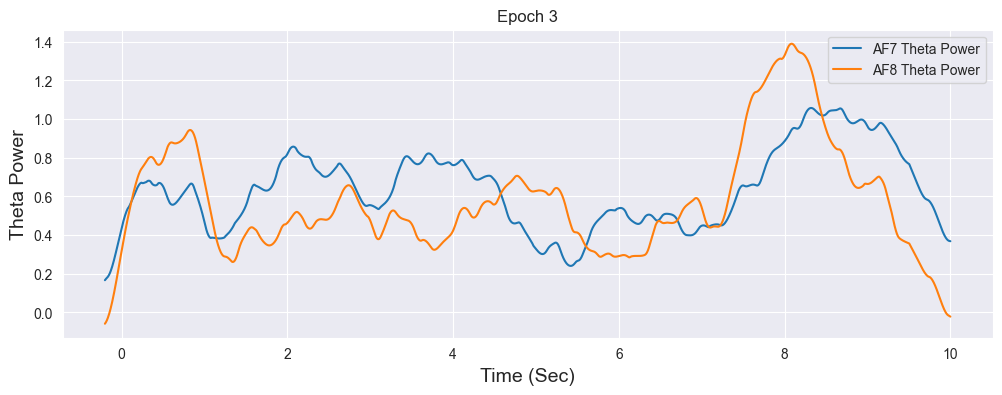

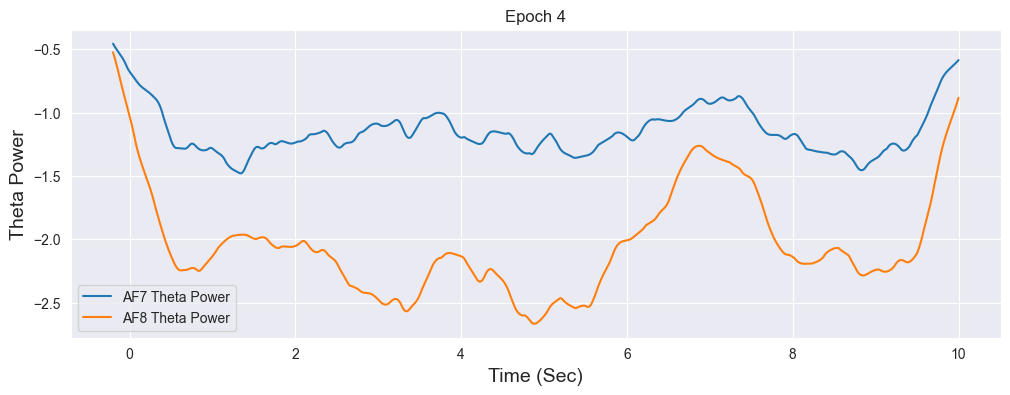

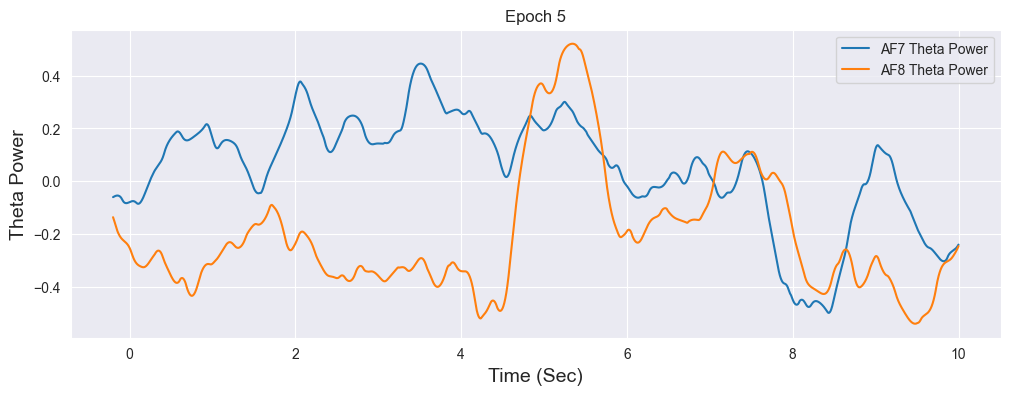

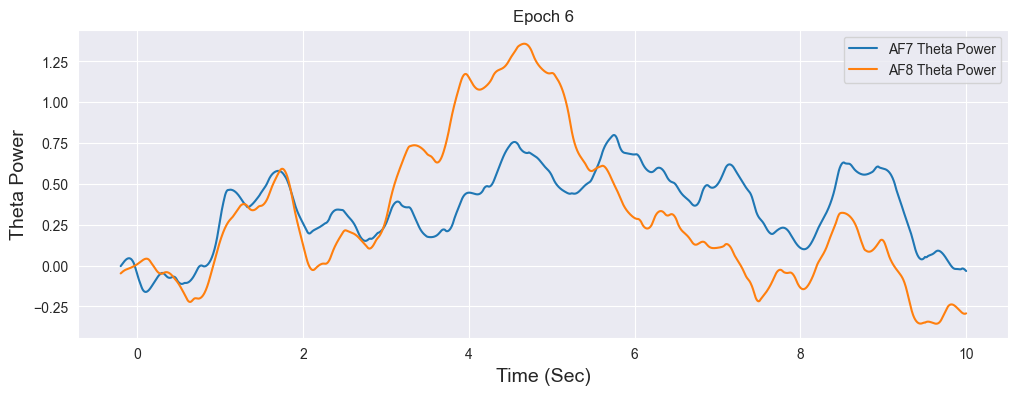

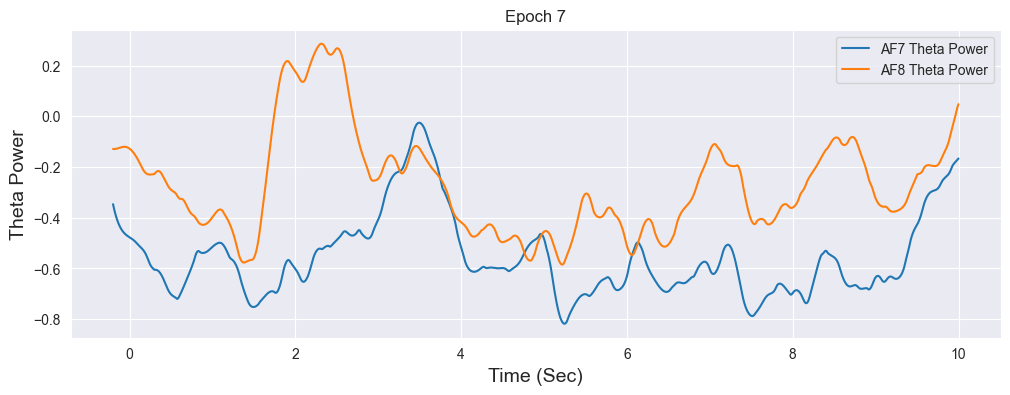

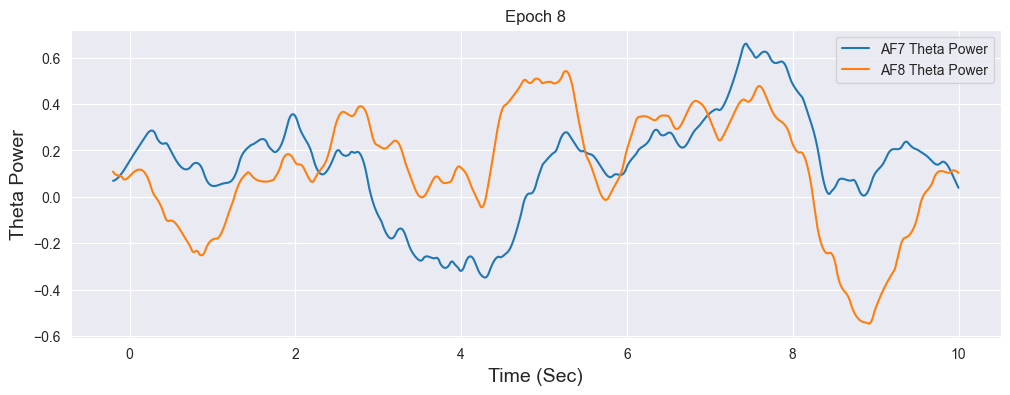

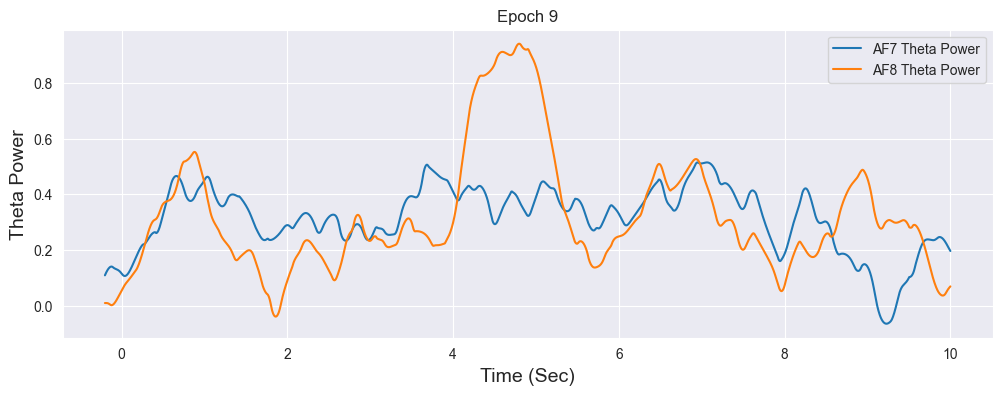

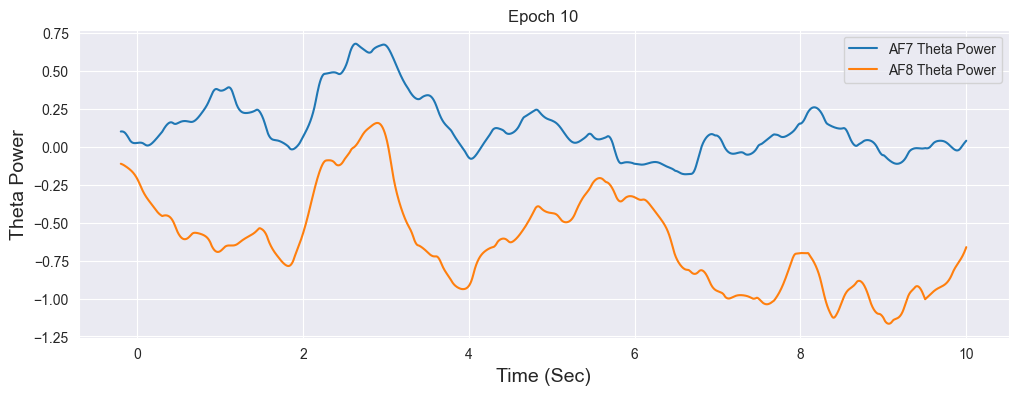

In [15]:
# moving average function
def moving_average(data, window_size=50):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='same') 

theta_power = power.data.mean(axis=2)  
time_points = power.times 

af7_index = 0  # AF7
af8_index = 3  # AF8

# Plot the smoothed power for each epoch
for i in range(theta_power.shape[0]):  
    # Calculate the moving average for each channel's power
    smoothed_af7_power = moving_average(theta_power[i, af7_index, :], window_size=250)
    smoothed_af8_power = moving_average(theta_power[i, af8_index, :], window_size=250)

    plt.figure(figsize=(12, 4))
    plt.plot(time_points, smoothed_af7_power, label='AF7 Theta Power')
    plt.plot(time_points, smoothed_af8_power, label='AF8 Theta Power')

    plt.title(f'Epoch {i+1}')
    plt.xlabel('Time (Sec)', fontsize=14)
    plt.ylabel('Theta Power', fontsize=14)
    plt.legend()
    plt.show()


# Theta asymmetry

Not setting metadata
Applying baseline correction (mode: logratio)


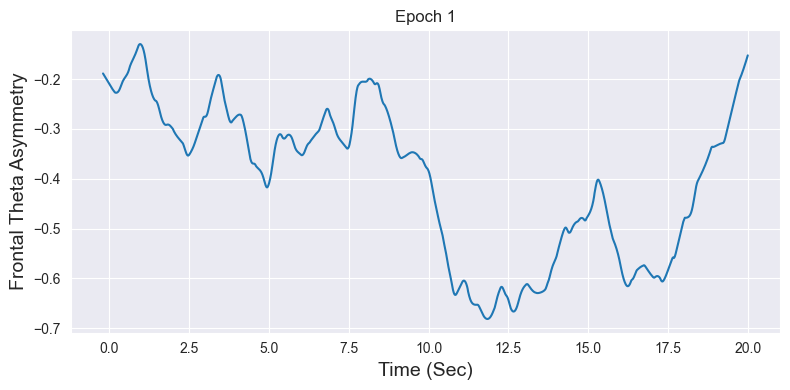

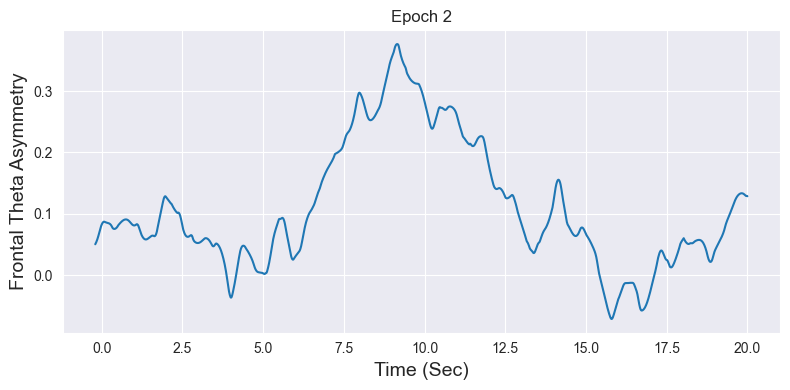

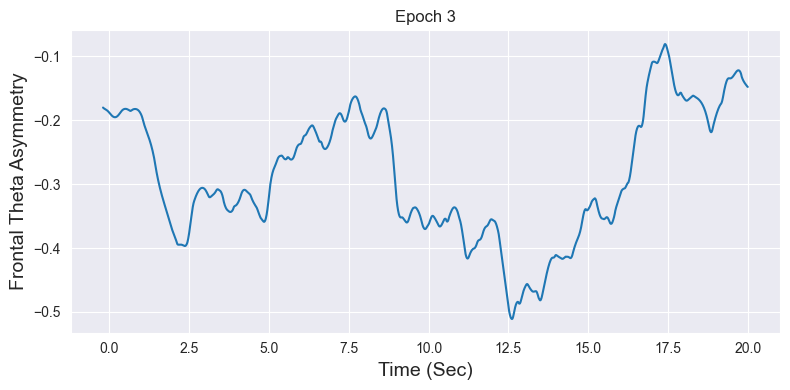

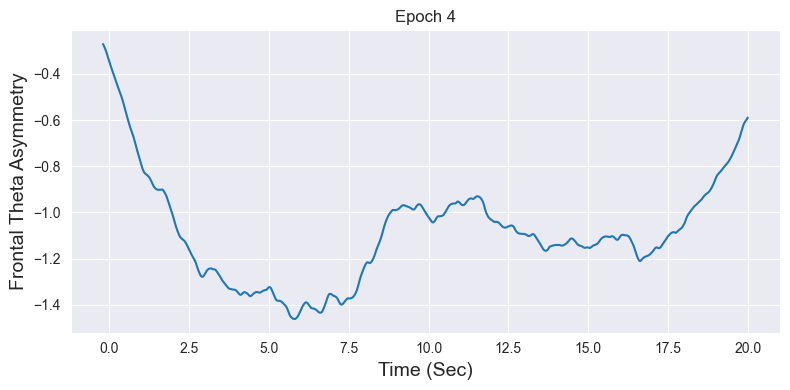

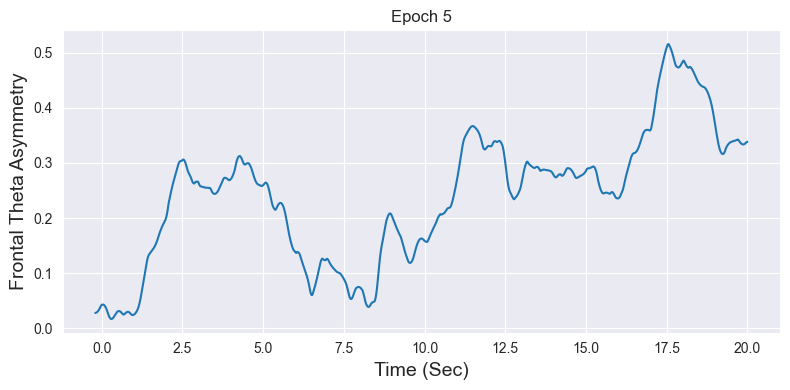

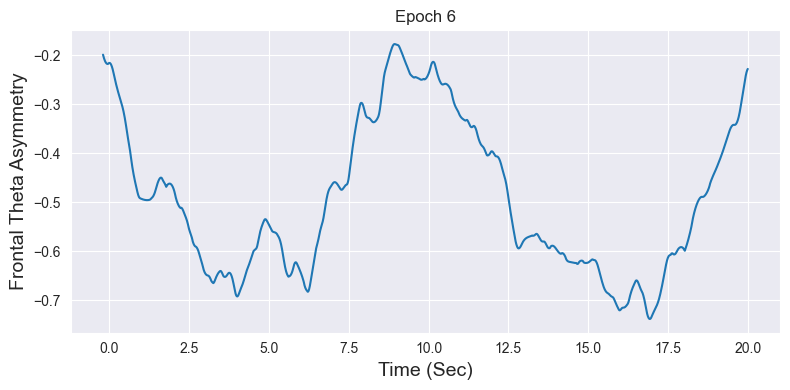

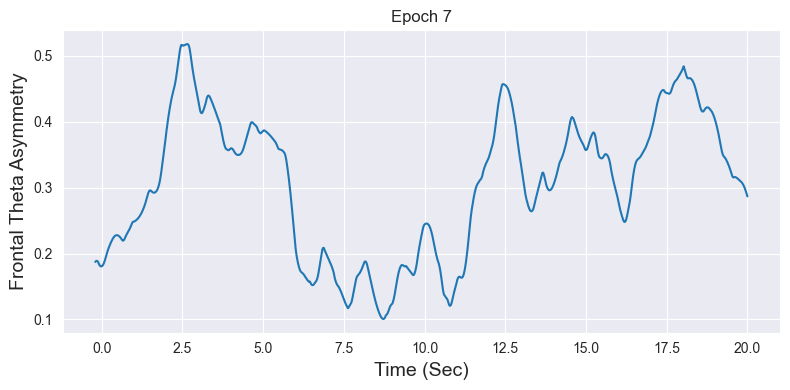

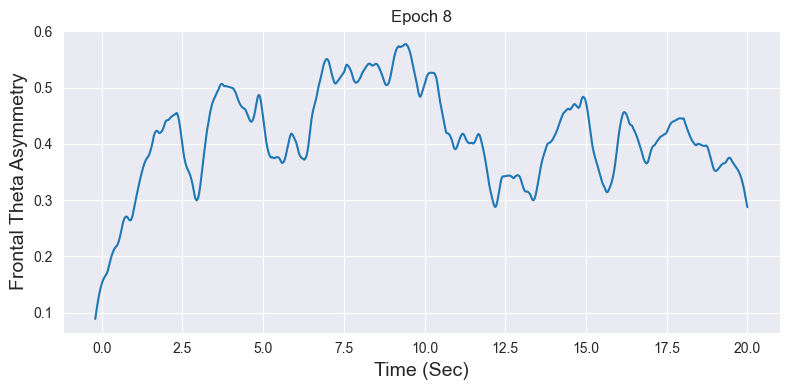

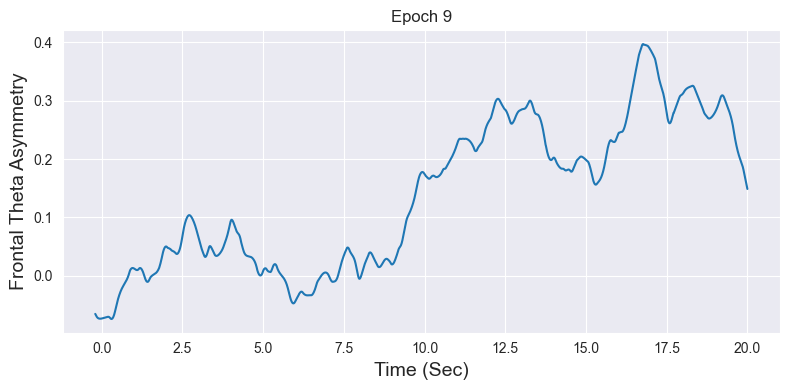

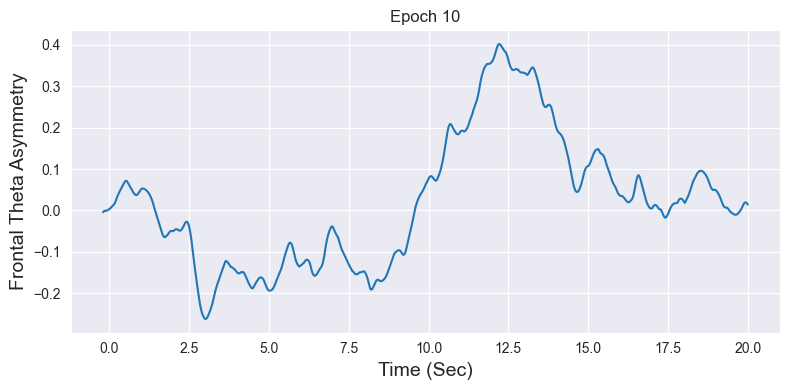

In [19]:
# regularization_constant = 0.1

# Apply moving average function
def moving_average(data, window_size=5):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='same')

frequencies = np.arange(4, 8, 1)  # Alpha band: 4-8 Hz
n_cycles = frequencies / 2.
power = mne.time_frequency.tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, return_itc=False, average=False)
power.apply_baseline(baseline=(-0.2, 0), mode='logratio') # baseline correction

theta_band = power.copy().crop(fmin=4, fmax=8).data
n_epochs = alpha_band.shape[0]
time_points = np.linspace(-0.2, 20, theta_band.shape[-1])

# Calculate and plot the frontal alpha asymmetry for each epoch
for i in range(n_epochs):
    # average across frequency
    af7_theta_power = alpha_band[i, 0, :, :].mean(axis=0)  # AF7
    af8_theta_power = alpha_band[i, 3, :, :].mean(axis=0)  # AF8

    # # Apply regularization constant before log transformation
    # af7_alpha_power += regularization_constant
    # af8_alpha_power += regularization_constant

    # Calculate the asymmetry index
    asymmetry_index = af8_theta_power - af7_theta_power
    smoothed_asymmetry_index = moving_average(asymmetry_index, window_size=500)

    plt.figure(figsize=(8, 4))
    plt.plot(time_points, smoothed_asymmetry_index)
    plt.title(f'Epoch {i+1}')
    plt.xlabel('Time (Sec)', fontsize=14)
    plt.ylabel('Frontal Theta Asymmetry', fontsize=14)
    plt.tight_layout()
    plt.show()

# Beta Power

Not setting metadata
Applying baseline correction (mode: logratio)


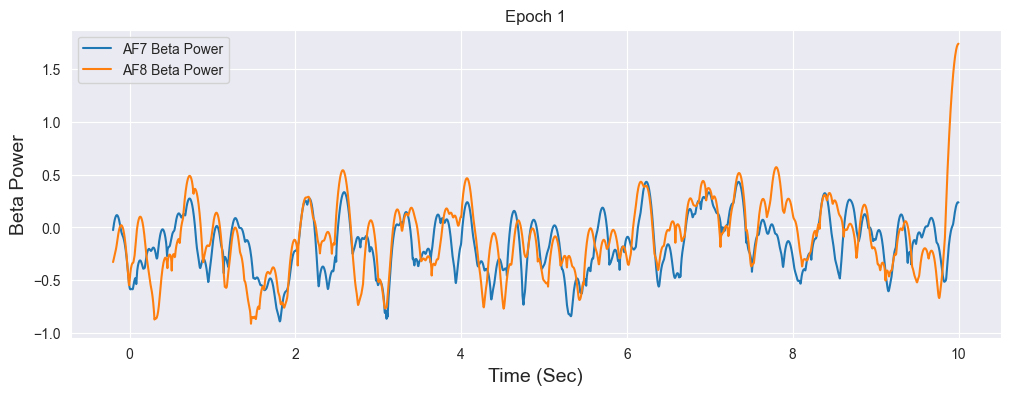

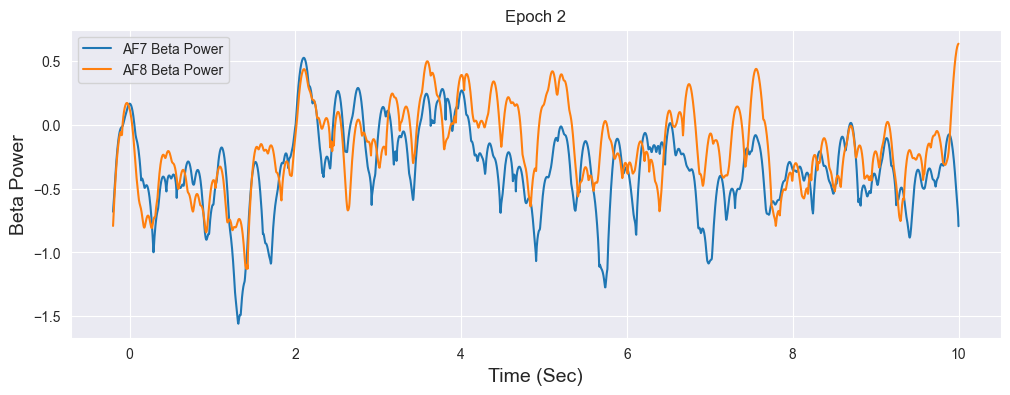

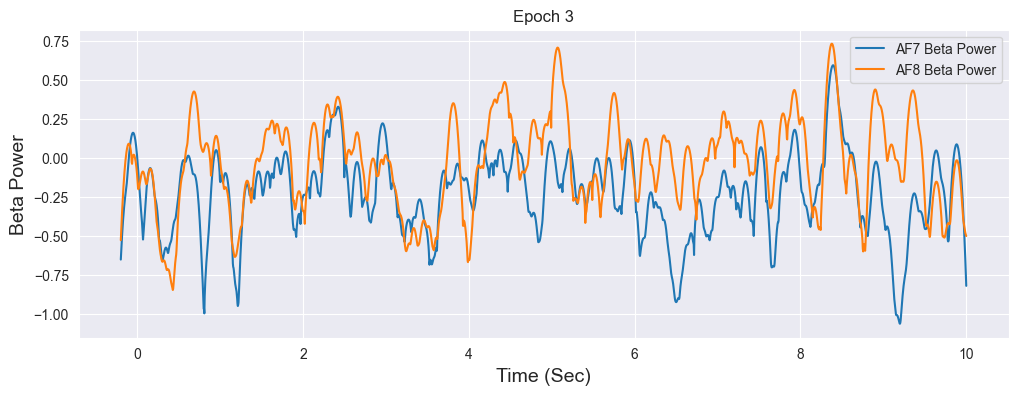

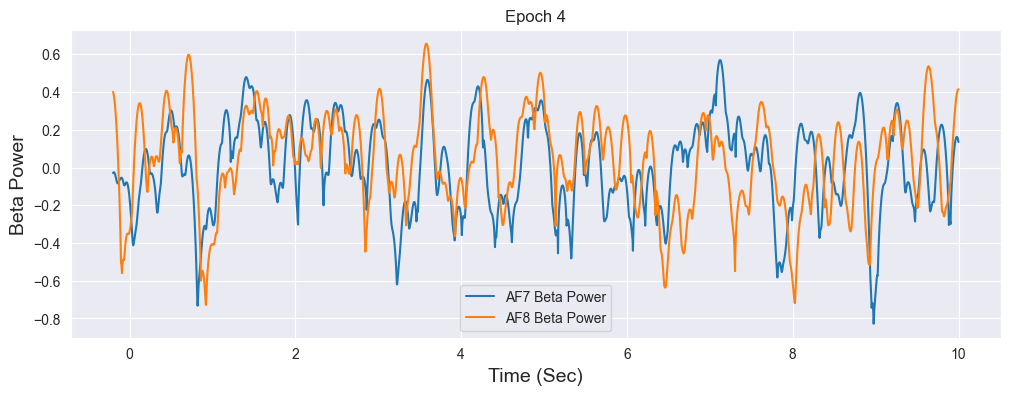

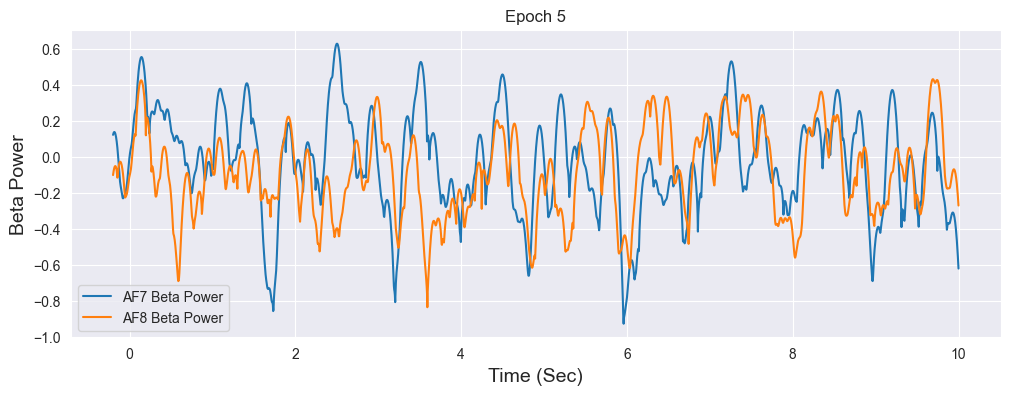

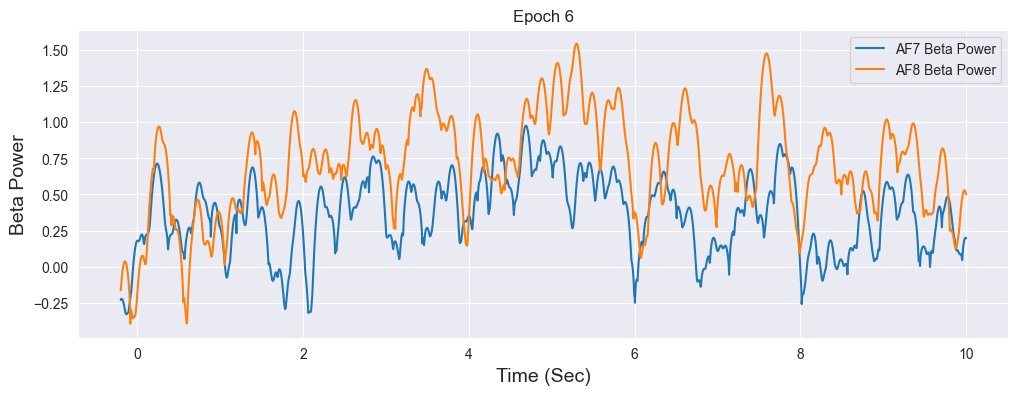

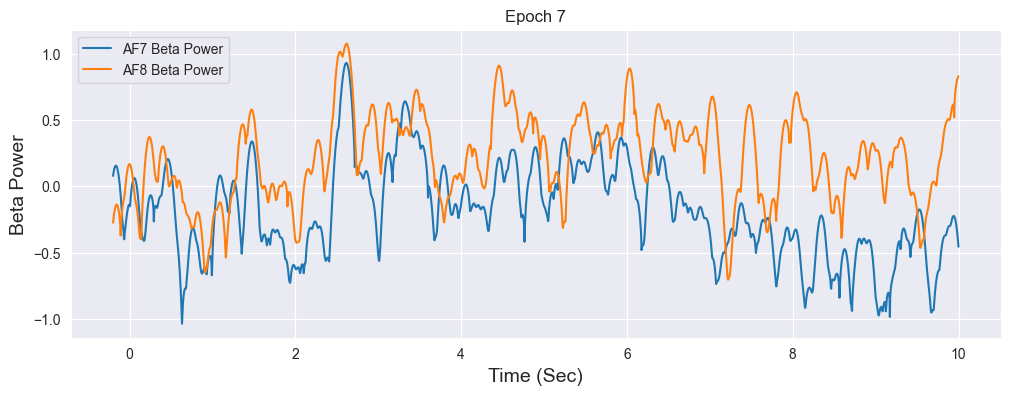

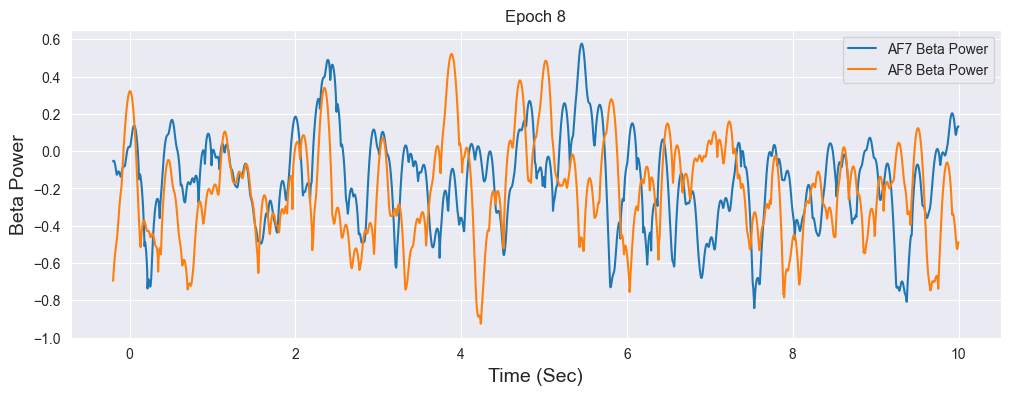

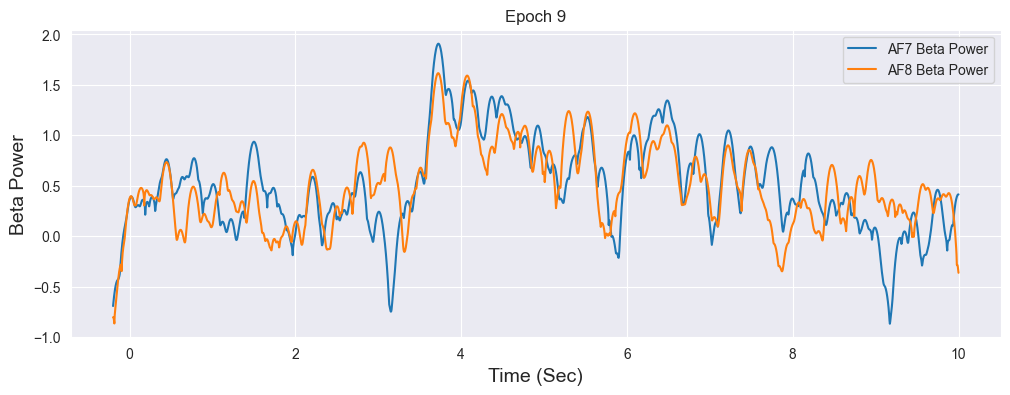

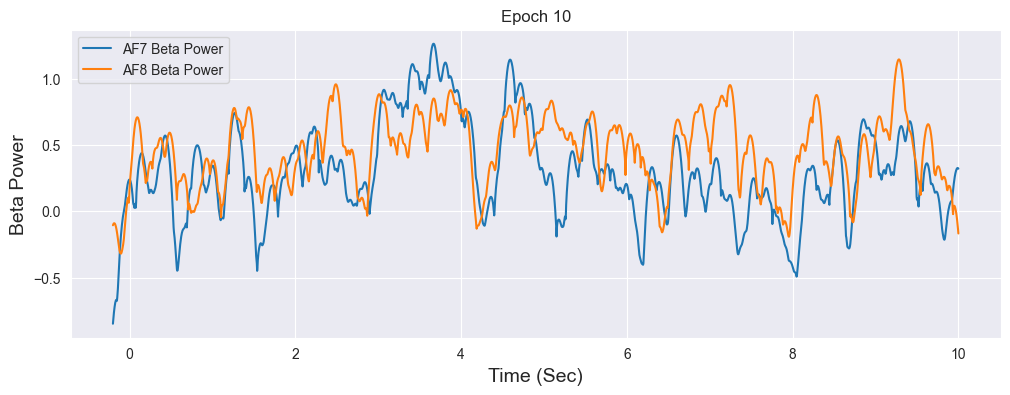

In [20]:
beta_freqs = np.arange(13, 31, 1)  # 13 to 30 Hz, in steps of 1 Hz

power = mne.time_frequency.tfr_morlet(epochs, freqs=beta_freqs, n_cycles=beta_freqs / 2,
                                      return_itc=False, average=False)

baseline_period = (-0.2, 0)
power.apply_baseline(baseline_period, mode='logratio') # baseline correction

af7_index = 0
af8_index = 3
time_points = power.times

# Plot the theta power for each epoch and channel
for i in range(len(power.data)):
    # Extract theta power for each channel and average across theta frequencies
    af7_beta_power = power.data[i, af7_index, :, :].mean(axis=0)
    af8_beta_power = power.data[i, af8_index, :, :].mean(axis=0)

    plt.figure(figsize=(12, 4))
    plt.plot(time_points, af7_beta_power, label='AF7 Beta Power')
    plt.plot(time_points, af8_beta_power, label='AF8 Beta Power')

    plt.title(f'Epoch {i+1}')
    plt.xlabel('Time (Sec)', fontsize=14)
    plt.ylabel('Beta Power', fontsize=14)
    plt.legend()
    plt.show()


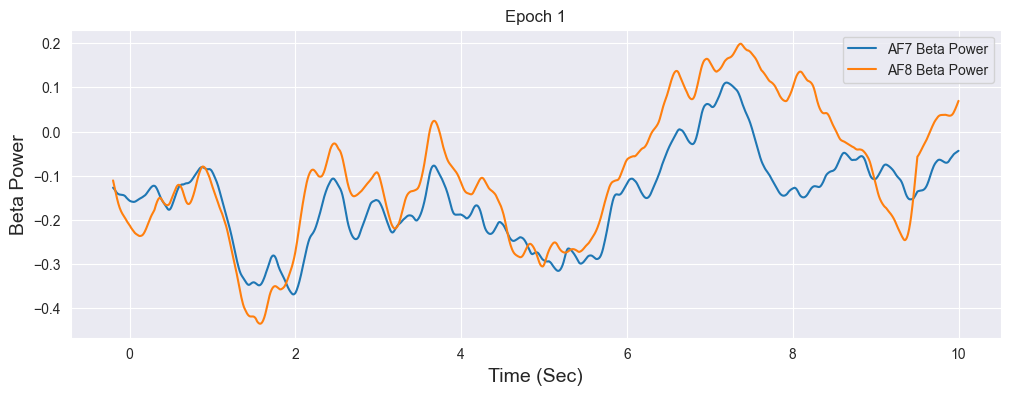

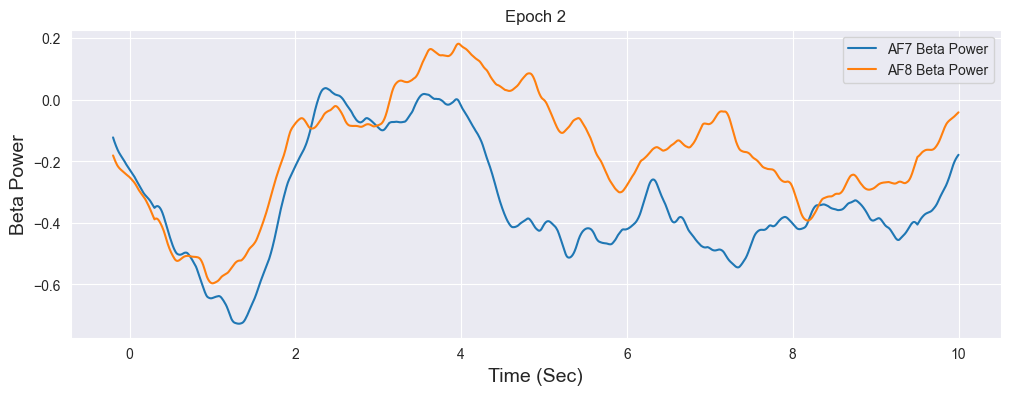

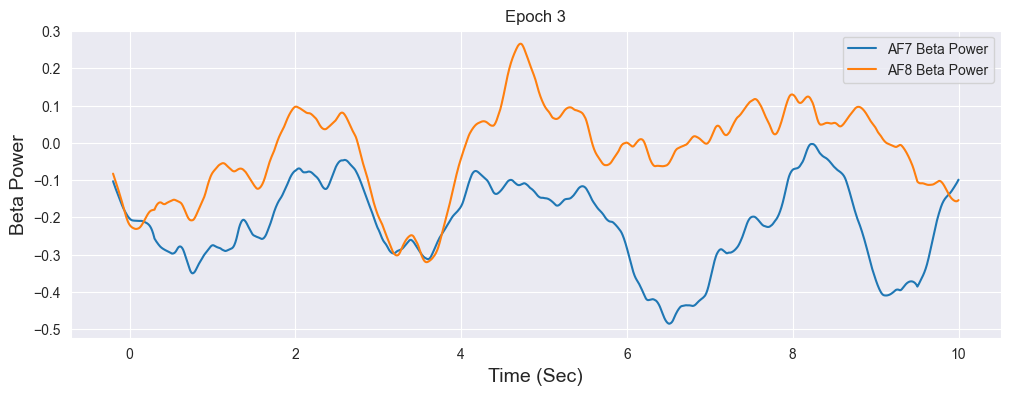

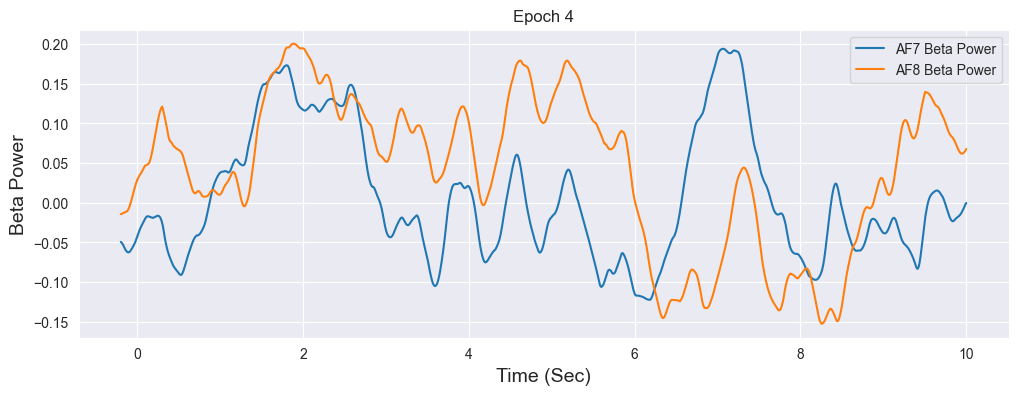

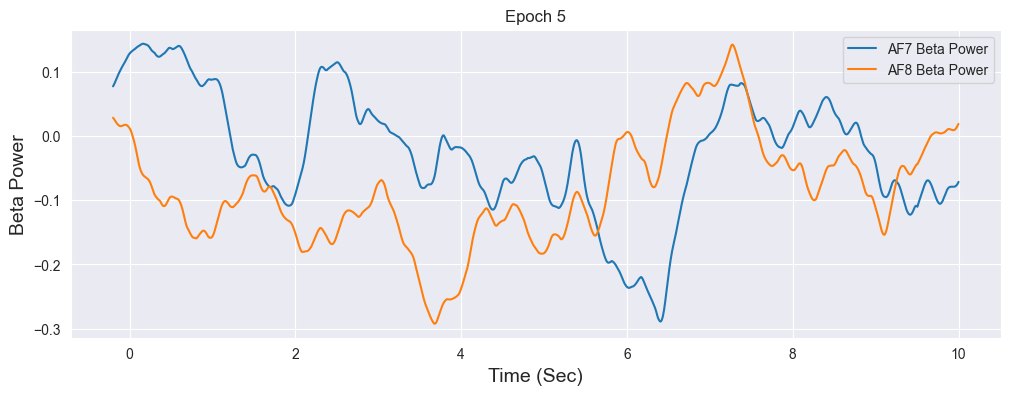

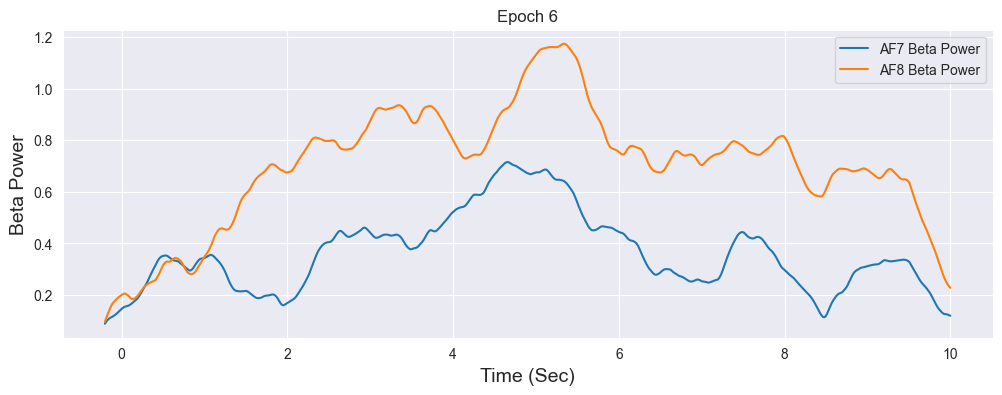

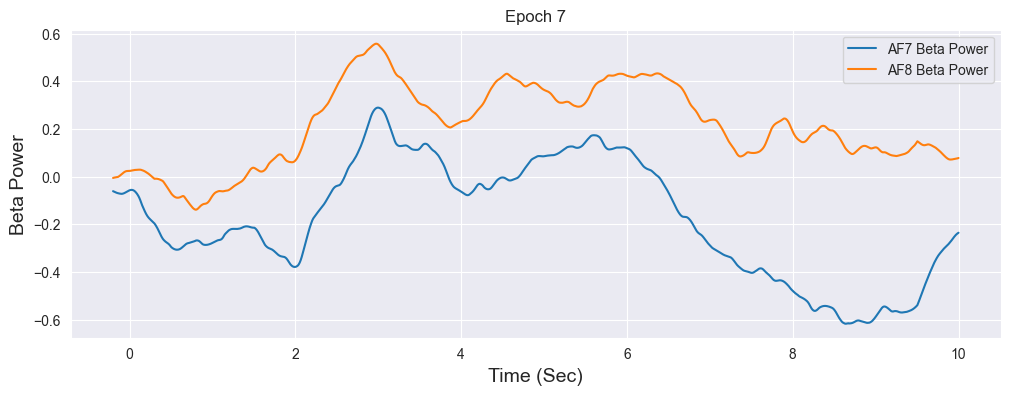

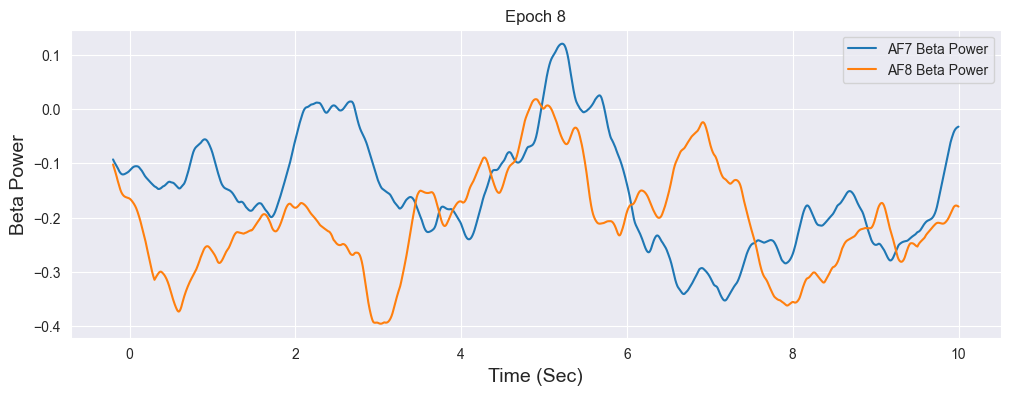

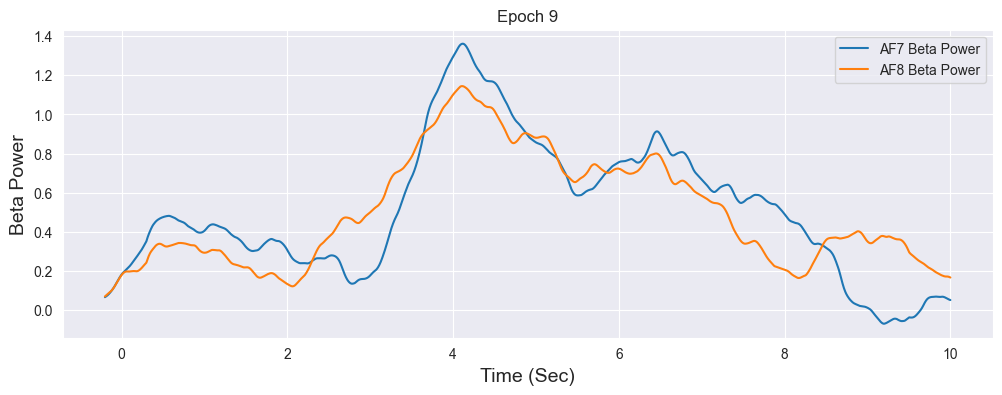

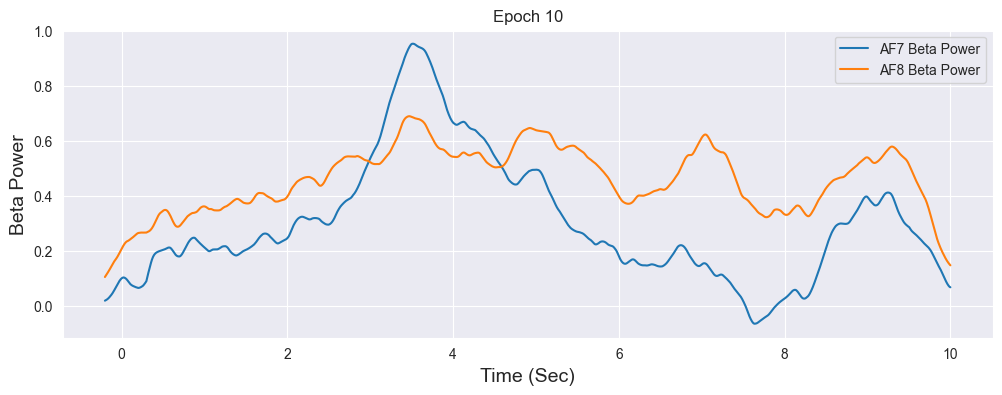

In [21]:
# moving average function
def moving_average(data, window_size=50):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='same')

beta_power = power.data.mean(axis=2)
time_points = power.times

af7_index = 0  # AF7
af8_index = 3  # AF8

# Plot the smoothed power for each epoch
for i in range(beta_power.shape[0]):
    # Calculate the moving average for each channel's power
    smoothed_af7_power = moving_average(beta_power[i, af7_index, :], window_size=250)
    smoothed_af8_power = moving_average(beta_power[i, af8_index, :], window_size=250)

    plt.figure(figsize=(12, 4))
    plt.plot(time_points, smoothed_af7_power, label='AF7 Beta Power')
    plt.plot(time_points, smoothed_af8_power, label='AF8 Beta Power')

    plt.title(f'Epoch {i+1}')
    plt.xlabel('Time (Sec)', fontsize=14)
    plt.ylabel('Beta Power', fontsize=14)
    plt.legend()
    plt.show()

# Beta asymmetry

Not setting metadata
Applying baseline correction (mode: logratio)


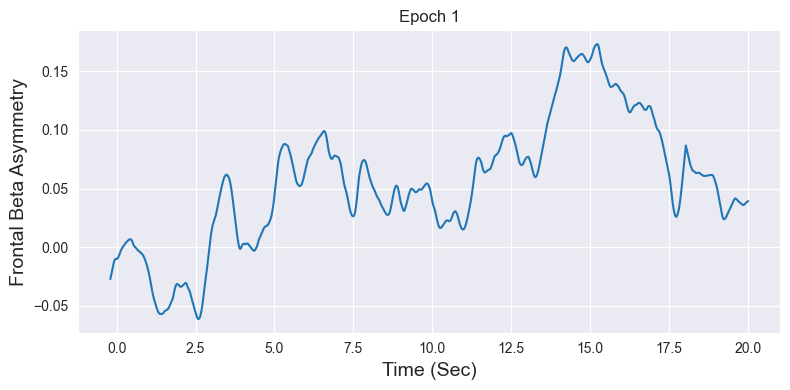

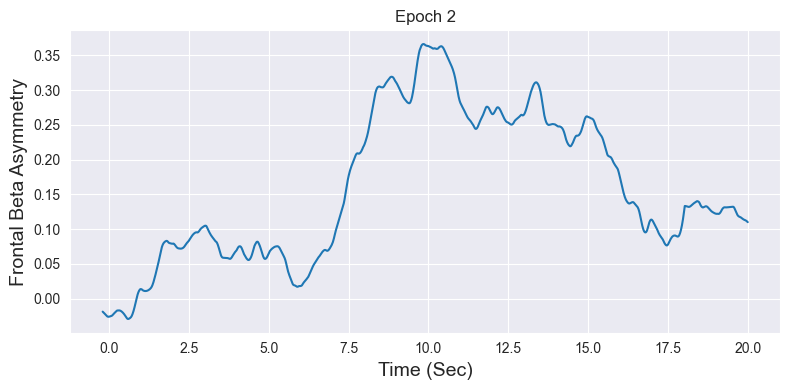

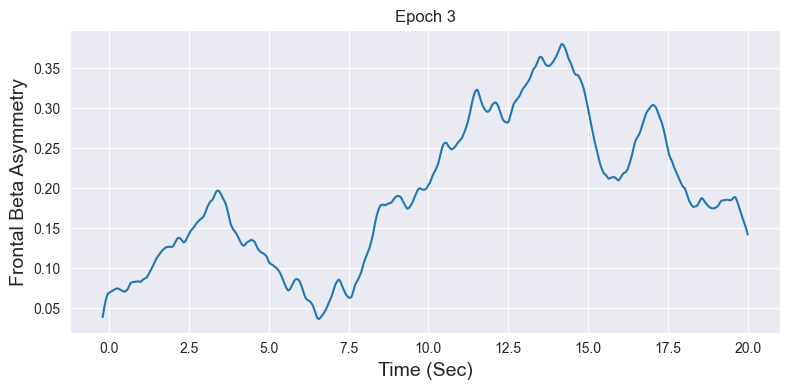

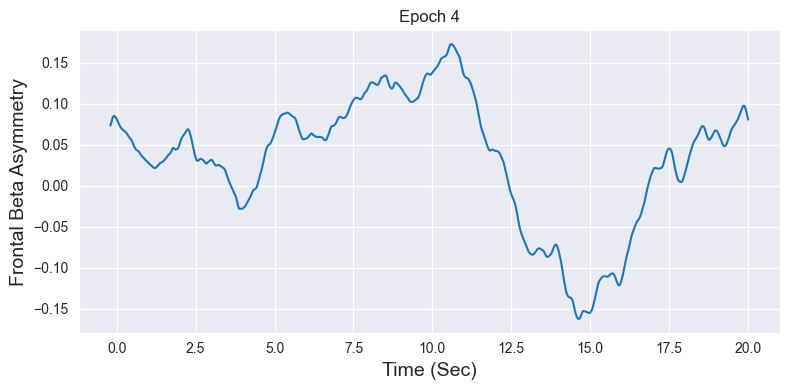

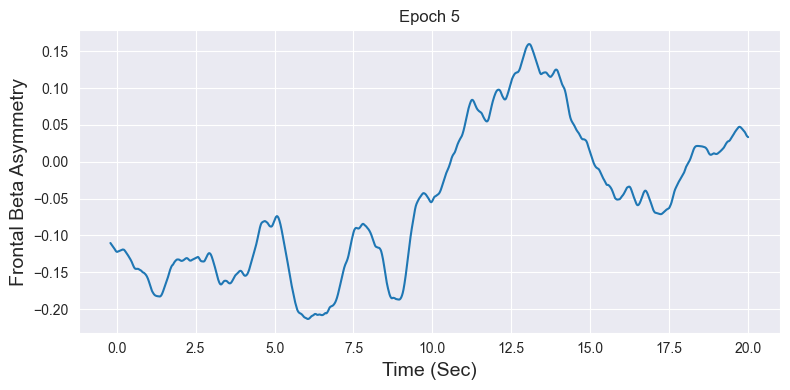

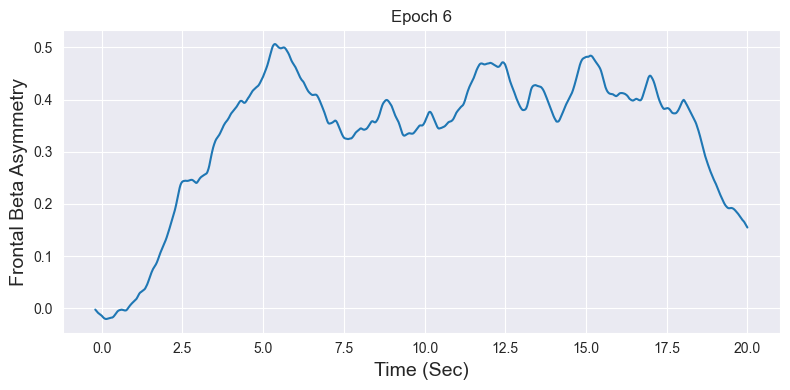

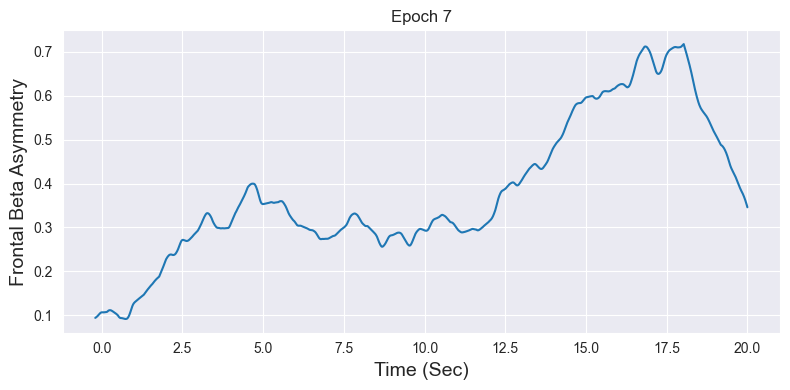

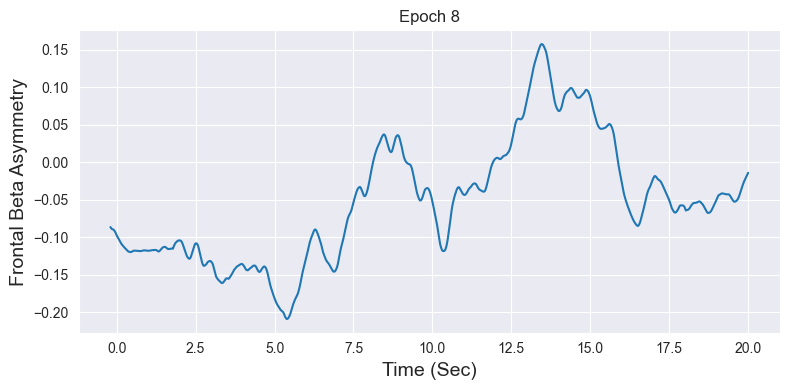

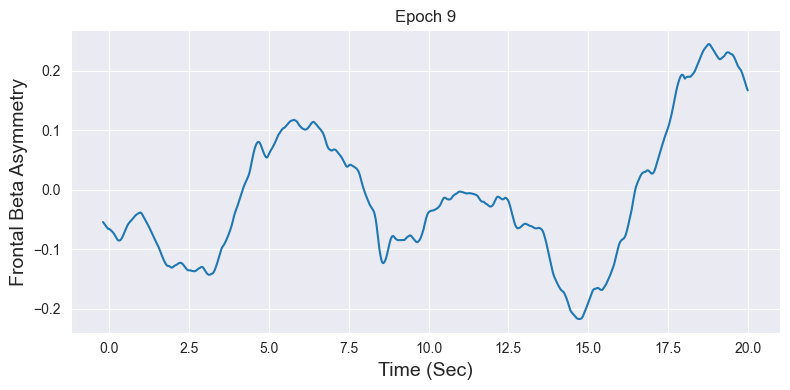

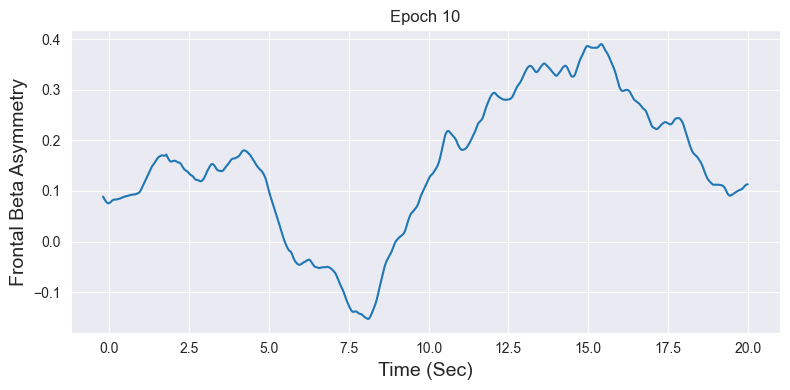

In [22]:
# regularization_constant = 0.1

# Apply moving average function
def moving_average(data, window_size=5):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='same')

frequencies = np.arange(13, 31, 1)  # Alpha band: 8-12 Hz
n_cycles = frequencies / 2.
power = mne.time_frequency.tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, return_itc=False, average=False)
power.apply_baseline(baseline=(-0.2, 0), mode='logratio') # baseline correction

beta_band = power.copy().crop(fmin=13, fmax=31).data
n_epochs = beta_band.shape[0]
time_points = np.linspace(-0.2, 20, beta_band.shape[-1])

# Calculate and plot the frontal alpha asymmetry for each epoch
for i in range(n_epochs):
    # average across frequency
    af7_beta_power = beta_band[i, 0, :, :].mean(axis=0)  # AF7
    af8_beta_power = beta_band[i, 3, :, :].mean(axis=0)  # AF8

    # # Apply regularization constant before log transformation
    # af7_beta_power += regularization_constant
    # af8_beta_power += regularization_constant

    # Calculate the asymmetry index
    asymmetry_index = af8_beta_power - af7_beta_power
    smoothed_asymmetry_index = moving_average(asymmetry_index, window_size=500)

    plt.figure(figsize=(8, 4))
    plt.plot(time_points, smoothed_asymmetry_index)
    plt.title(f'Epoch {i+1}')
    plt.xlabel('Time (Sec)', fontsize=14)
    plt.ylabel('Frontal Beta Asymmetry', fontsize=14)
    plt.tight_layout()
    plt.show()